In [173]:
import io
import json

import requests
import pandas as pd
import numpy as np

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats._continuous_distns import _distn_names

In [174]:
state_to_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
abbrev_to_state = {v:k for k,v in state_to_abbrev.items()}

class DfLoader:
    def __init__(self,):
        self.pre_df = []
        self.df = None
        self.source_url = None
        self.source_type = None
        
    
    def df_from_url(self, url):
        self.source_url = url
        self.source_type = 'web'
        req = requests.get(self.source_url)
        with io.StringIO(req.content.decode('utf-8')) as f:
            try:
                self.df = pd.read_csv(f, delimiter=',')
            except: # something went wrong in the autoloader
                for line in f:
                    self.pre_df.append(line)
        
                    
    def as_not_in_b(self,vals_a,vals_b):
        a = sorted(vals_a.drop_duplicates().values)
        b = sorted(vals_b.drop_duplicates().values)
        return [elem for elem in a if elem not in b]

    
def apply_dic(dic, elem):
    try:
        return dic[elem]
    except:
        return None
    
def compute_fn(a,b,fn,nan_val=None):
    if pd.isnull(a): return nan_val
    if pd.isnull(b): return nan_val
    return fn(a,b)

matplotlib.style.use('ggplot')

# Create models from data
# https://stackoverflow.com/a/37616966/7032846
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True,) # density=True
    x = (x + np.roll(x, -1))[:-1] / 2.0
    DISTRIBUTIONS = [getattr(scipy.stats, distname) for distname in _distn_names if 'expon' in distname]

    # Best holders
    best_distribution = [DISTRIBUTIONS[0]]
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name)

                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Header
We knew this day would come.  On March 29, 2021 I recieved an e-mail invitation from the Indiana State Department of Health to take the COVID-19 vaccine.  I hold the somewhat unpopular belief that COVID-19 is not the most pressing issue in our society, but it is among the most pressing at best.  I remain cautious because I also believe that the clinical measurement and data tracking systems which should have reliably tracked COVID-19 have largely failed to do so.  

So why bother?  Close examination of these data sources serves 2 main purposes.  Most importantly it enables me to tease apart what is fact and what is false in the world.  Secondly, while the data systems have failed at thier ultimate goal of providing an unbiased and efficient account of the events relevant to COVID-19, they were our well-funded best shot.  So they provide a good example of data structures and "best-practices", so as a data practitioner hard to ignore.

## Coronavirus Vaccination In-the-Wild
Passionate citizens will advocate for or against the choice to get vaccinated, but I have yet to see any thorough investigation of the questions I have about he vaccine. "industry experts"  As I am 35 years old with residence in Indiana, USA, until this week it was not an option for me to get vaccinated so I didn't care.  This issue has become politicized so I find myself skeptical reading 3rd party analyses regarding the coronavirus, its impact and the efficacy of the vaccine.  So, I am going to look at the data myself.  Examining the state-level data for the following:
1. When did each state begin vaccinations, who was first, last, average? Statistically significant?
2. Which states were fastest, slowest, average at vaccinating people?  Statistically significant?
3. Which states were most effective at fully vaccinating people?  Statistically significant?
4. Which states improved their vaccinations efforts the fastest, slowest, average?  Statistically significant?
5. Which states saw the biggest, smallest, average impact of vaccination on reducing new cases?  Statistically significant?
6. Which states saw the biggest, smallest, average impact of vaccination on reducing deaths?  Statistically significant?
7. Which states saw the biggest, smallest, average impact of vaccination on reducing deaths per new cases? Statistically significant?

Confounds and concerns:
1. What percentage of population had tested positive for coronavirus at the time that vaccinations start?  (e.g. what was the size of the eligible population?)
2. How much inter-personal high risk activity was happening in the population?
3. How much mis-diagnosis was happening?  How much noise in the dataset?  Which states were best at reporting cases?
4. Which variant of the vaccination was administered?
5. To what extent did behavior change impact the reduction in cases/deaths vs the vaccine?

## Data Sources
1. NYTimes Covid-19 cases tracker hosted [data](https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv) [definitions](https://github.com/nytimes/covid-19-data)
2. Oxford Covid-19 Government Response Tracker (OxCGRT) [data](https://github.com/GoogleCloudPlatform/covid-19-open-data) [definitions](https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md)
3. OWID [data](https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv) [definitions](https://github.com/owid/covid-19-data/tree/master/public/data/vaccinations)
4. US Census State-level Population [data](https://api.census.gov/data/2019/pep/charagegroups?get=NAME,POP&for=state:*) [definitions](https://www.census.gov/data/developers/data-sets/popest-popproj.html)

### Notes on other data sources
I started using OWID source, as it was the first returned in a google search, and it smelled bad.  Mainly, that smell was triggered by the dataset's showing that all the states started vaccination on the same day (2021-01-12).  Furthermore, it showed that 100s of thousands of individuals were vaccinated on that first day for every state.  That seemed highly suspect to me so that's when I looked elsewhere.  To corroborate the data, the best event timeline in the Oxford Covid-19 Government Response Tracker. After examining OxCGRT, we find corroboration that OWID is missing key information in the beginning of the US vaccination campaign.

## Data Preprocessing

In [175]:
vax_data_url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv"
cvd_data_url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
oxf_data_url = "https://storage.googleapis.com/covid19-open-data/v2/oxford-government-response.csv"
pop_data_url = "https://api.census.gov/data/2019/pep/charagegroups?get=NAME,POP&for=state:*"
vax = DfLoader()
vax.df_from_url(url=vax_data_url)
cvd = DfLoader()
cvd.df_from_url(url=cvd_data_url)
oxf = DfLoader()
oxf.df_from_url(url=oxf_data_url)
pop = DfLoader()
pop.source_url = pop_data_url
pop.source_type = 'web'
s = json.loads(requests.get(pop_data_url).content)
pop.df = pd.DataFrame(s[1:], columns=s[0])

In [176]:
cvd.df.date = pd.to_datetime(cvd.df.date)
vax.df.date = pd.to_datetime(vax.df.date)
oxf.df.date = pd.to_datetime(oxf.df.date)

vax_replaces = {
    'location': [['New York State', 'New York']]
}
vax.df = (vax.df[vax.df['location'] != 'United States']).copy()

# overwrites the same column
for col,reps in vax_replaces.items():
    for rep in reps:
        vax.df[col].replace(rep[0],rep[1],inplace=True)


In [177]:
us_st = [
    loc for loc 
    in oxf.df.key.dropna().drop_duplicates().values 
    if str(loc)[:3] == 'US_'
]
oxf.df = oxf.df[oxf.df.key.isin(us_st)]
  
oxf.df['state_name'] = oxf.df.key.apply(
    lambda x: 
    apply_dic(dic=abbrev_to_state, elem=x[-2:])
)

### Vaccination policy is a categorical
We look to the definition of `vaccination_policy`.
> 0 - No availability  
1 - Availability for ONE of following: key workers/ clinically vulnerable groups (non elderly) / elderly groups  
2 - Availability for TWO of following: key workers/ clinically vulnerable groups (non elderly) / elderly groups  
3 - Availability for ALL of following: key workers/ clinically vulnerable groups (non elderly) / elderly groups  
4 - Availability for all three plus partial additional availability (select broad groups/ages)  
5 - Universal availability  

In [178]:
oxf.df['vaccination_policy'] = pd.Categorical(oxf.df['vaccination_policy'], ordered=True)

### Data Quality
#### NYTimes Covid-19
>Starts: 2020-01-21  
Ends: 2021-03-31  
Today: 2021-04-01  
Full State Record on Vaccination Response variable:   
    >>start: 2020-03-13  
    end: 2021-03-31  
    not full: [<=2020-03-12]  
    subset of states always reporting: [Washington]  

Conclusions:
  - We remove the data prior to 2020-03-13.
    
#### OxCGRT
> Starts: 2020-01-01  
Ends: 2021-03-30  
Today: 2021-04-01  
Full State Record on Vaccination Response variable:   
    >>start: 2020-09-14  
    end: 2021-03-29  
    not full: [2020-12-08, >= 2021-02-12]  
    subset of states always reporting: []  

Conclusions: 
  - We assume that prior to 2020-09-14, there were no known vaccinations, thus those NaNs are actually 0s

#### OWID Vaccination Data (State-level Data)
> Starts: 2020-12-20  
Ends: 2021-03-31  
Today: 2021-04-01  
Full State Record on Vaccination Response variable:   
    >>start: 2020-09-14  
    end: 2021-03-29  
    not full: [2020-12-08, >= 2021-02-12]  
    subset of states always reporting: []  
  
Conclusions:
  - This dataset may prove useful for some questions besides when each state started providing vaccinations.


#### NYTimes Data Quality

In [179]:
%%capture
# diagnostic looking at number of states reporting, by day on the nytimes source
[(date,len(data.state.drop_duplicates().values)) for date, data in cvd.df.groupby('date')]

#### OxCGRT Data Quality

In [180]:
%%capture
# diagnostic looking at number of states reporting, by day on the oxford source
[(date,len(data.state_name.drop_duplicates().values)) for date, data in oxf.df.dropna(subset=['vaccination_policy']).groupby('date')]

#### OWID Data Quality

In [181]:
vax.df.date.min(),vax.df.date.max()

(Timestamp('2021-01-12 00:00:00'), Timestamp('2021-04-07 00:00:00'))

In [182]:
vax.df.sort_values('date').head()

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207
2838,2021-01-12,Missouri,161784.0,485175.0,107939.0,0.36,2.64,22155.0,1.76,7.91,NaN,NaN,NaN,0.333
258,2021-01-12,Arizona,141355.0,563025.0,95141.0,0.11,1.94,8343.0,1.31,7.74,NaN,NaN,NaN,0.251
2752,2021-01-12,Mississippi,54544.0,212050.0,45733.0,0.16,1.83,4832.0,1.54,7.12,NaN,NaN,NaN,0.257
4925,2021-01-12,Vermont,25757.0,64925.0,NaN,NaN,4.13,NaN,NaN,10.40,NaN,NaN,NaN,0.397


In [183]:
vax_start_dates = []
for state, data in vax.df.groupby(by=['location']):
    a = data[data['total_vaccinations'] != 0.0]
    b = a.sort_values('date').iloc[0]
    c = b.to_dict()
    vax_start_dates.append(c)
{obj['date'] for obj in vax_start_dates}

{Timestamp('2021-01-12 00:00:00')}

### Countermeasures for Data Quality

In [184]:
# here we slice off the incomplete dates at the beginning
cvd.df = cvd.df[cvd.df['date'] >= '2020-03-13']

# here we assume that NaNs prior to 2020-09-14 are 0-no availability
oxf_nan_to_0_assump_mask = oxf.df['date'] <= '2020-09-14'
oxf.df.loc[oxf_nan_to_0_assump_mask, 'vaccination_policy'] = \
    oxf.df.loc[oxf_nan_to_0_assump_mask, 'vaccination_policy'].fillna(0)

## Investigations
### On what date did each state begin vaccinations, who was first, last, average? Statistically significant?
Procurement for the coronavirus vaccine occurred on a state level, and not all states started at the same time.  Here we consider the date on which vaccinations became non-zero for each state ("0-No Availability").  The measure of statistical significance is based on the distribution of the dates, and we will describe anomalies and statistically significant anomalies.  Charting the density, for each day, we count the number of states that started vaccinating.  So, we need to compute the date on which vaccinations were first available.  

Please feel free to leave comments if you know more about how this process was run, and why some states were slower than others to administer their first vaccines.  The author also leaves open the possiblity that the Oxford dataset is wrong about the specific dates.

#### Early, Normal and Late States In Vaccination Access
>First state: Oklahoma (2020-12-11)  
Last state: Arizona (2021-01-05)  
Average date: (2020-12-15)  
Median date: (2020-12-15)  
Standard Deviation: 3.74 days

#### Anomalies and Statistical Significance
The typical state started vaccinating its population on Dec 15, 2020.  There were 3 states that started late, starting with the latest: Arizona, Nebraska and Missouri (in that order).  Arizona and Nebraska could be considered statistically significant anomalies as they were more than 3 standard deviations from the mean.

#### Code and Charts

In [185]:
vax_start_dates_oxf = []
for state, data in oxf.df.groupby('state_name'):
    a = data[data['vaccination_policy'] != 0.0]
    b = a.sort_values('date').iloc[0]
    c = b.to_dict()
    vax_start_dates_oxf.append(c)  
vax_start_dates_oxf = pd.DataFrame(vax_start_dates_oxf)

In [186]:
first_vax = vax_start_dates_oxf.date.min()
vax_start_dates_oxf['days_from_first'] = vax_start_dates_oxf['date'].apply(lambda x: (x-first_vax).days)

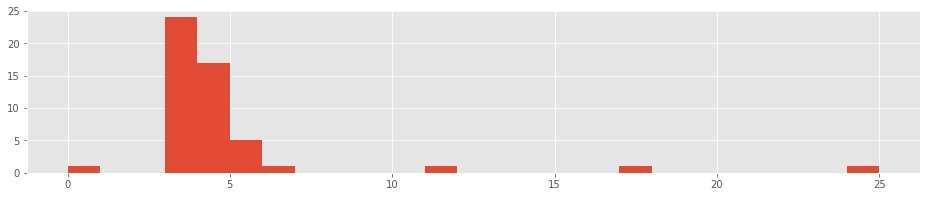

In [187]:
vax_start_dates_oxf['days_from_first'].hist(
    bins=vax_start_dates_oxf['days_from_first'].max(), 
    figsize=(16,3), grid=True,
)

For each day after Dec 11, the number of states that started vaccinating.

In [188]:
states_by_vax_start_dates_oxf = {}
for date, data in vax_start_dates_oxf.groupby('date'):
    states_by_vax_start_dates_oxf[str(date.date())] = list(data['state_name'].values)

In [189]:
vax_start_dates_oxf.date.mean(), pd.Timedelta(vax_start_dates_oxf.days_from_first.median(),unit='D') + first_vax

(Timestamp('2020-12-15 09:24:42.352941056'), Timestamp('2020-12-15 00:00:00'))

In [190]:
vax_start_dates_oxf['std_from_mean'] = (vax_start_dates_oxf.days_from_first-vax_start_dates_oxf.days_from_first.mean()) / vax_start_dates_oxf.days_from_first.std()

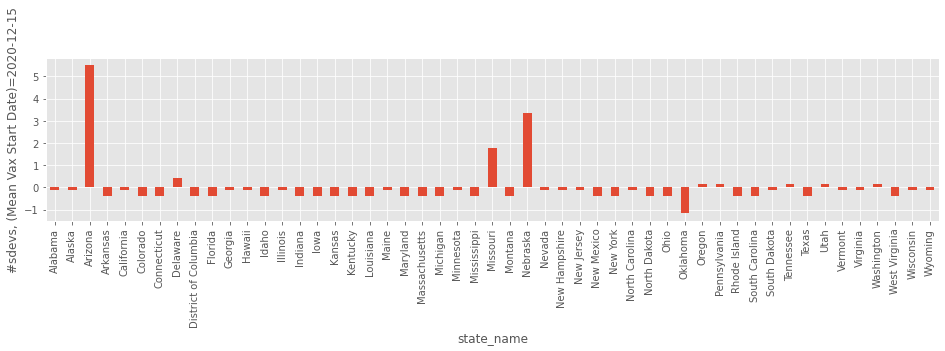

In [191]:
chart_wow = vax_start_dates_oxf[['state_name','std_from_mean']]
chart_wow.index = vax_start_dates_oxf['state_name']
del chart_wow['state_name']
chart_wow.plot(
    ylabel='#sdevs, (Mean Vax Start Date)=2020-12-15', 
    kind='bar',figsize=(16,3), legend=False, grid=True
)

### Vaccination Pace: which states were fastest, slowest, average at vaccinating people? Statistically significant?
There are two datasets loaded up that contain information about state-wide rollout pace.  The objective is to vaccinate as many of their citizens as possible, as soon as possible.  So every day, we will examine the leaderboard.  So for this one, we will compute a function for every date that returns the ordered list of number of vaccinations.  For this, we will use the OWID data set which contains counts of vaccinated.  We will add two new values to the dataset:
1. vaccinations administered by the 2019 census population of each state
2. days from start

In [192]:
state_to_pop = {obj['NAME']: int(obj['POP']) for obj in pop.df.to_dict('records')}
state_to_start = {obj['state_name']: obj['date'] for obj in vax_start_dates_oxf.to_dict('records')}

In [193]:
# remove states in vax not in census
adj_vax = vax.df[vax.df.location.isin(state_to_pop.keys())].copy()
adj_vax = vax.df[vax.df.location.isin(state_to_start.keys())].copy()

In [194]:
# adjust the owid vaccinations by state population

adj_vax['adj_total_vaccinations'] = adj_vax.apply(
    lambda x: x['total_vaccinations'] / float(state_to_pop[x['location']]),
    axis=1
)
adj_vax['people_vaccinated_%pop'] = adj_vax.apply(
    lambda x: x['people_vaccinated'] / float(state_to_pop[x['location']]),
    axis=1
)
adj_vax['people_fully_vaccinated_%pop'] = adj_vax.apply(
    lambda x: x['people_fully_vaccinated'] / float(state_to_pop[x['location']]),
    axis=1
)
adj_vax['days_from_start'] = adj_vax.apply(
    lambda x: (x['date'] - state_to_start[x['location']]).days,
    axis=1
)

#### Pace Leads and Statistical Signficance
To determine if the lead is statistically significant, we will use the distribution of the "pace lead" as %difference between the `(k-1)-th` and `k-th` observed value for the pace measure.  So there will be 50 per day observed, `N=40*50=2000` observations bordering on a significant sample size to examine this question.  Because we are calculating the pace lead based on the ordered list of daily ranks, we are modeling via order statistics, and will examine the assumption "a lead is a lead" by comparing the distributions of the `j-th` and `k-th` "pace lead" where `j != k`.

#### Issue with non-monotic cumulative totals (Article2)
[(Bloomberg, 2021-01-21)](https://www.bloomberg.com/news/live-blog/2021-01-21/methodology-and-analysis-for-the-covid-19-vaccine-tracker#60319089B2240006) describes the issue we observe where the cumulative sum of `people_vaccinated`.  The effective date of the CDC policy change impacting the OWID dataset are not all the same so it complicates comparisons between state vaccine regimes.  I originally detected the effect of this policy change by looking for instances where the change-over was substantial enough to cause the people_vaccinated to be less than it was the day before the policy change. For the states where the series becomes non-monotonic, that day most certainly was the start and it makes sense that D.C. would experience a large change given it is the largest concentration of federal employees relative to population. However, that is most likely not the extent of the effect -- other states may have had more subtle while still significant impacts. Has anyone developed better methodologies for quantifying the impact of the policy change? 
    
- States began the new CDC counting procedure on different days
- States experience different effect sizes, some of which are hard to detect, while Washington D.C. experienced a huge effect because the CDC began counting federally administered vaccines differently
So, what to do?
- we could calculate the DOD %difference from the current dataset, throwing away the anomalous one when the effect took place.  Then we could recalculate a new `people_vaccinated` estimate based on the differences.  This would result only in throwing away 1 day of data for each state.  This may reduce our total dataset under the current rule that all 50 states must be reporting every day of comparison.  So we don't remove the first-days entirely, but instead we can add another row to indicate that it is the first day which will act as a caveat in forming the leader boards.  Then we don't lose weeks of data, we just reduce `N` in the "pace lead" distribution by 1 day for each state, and the leaderboard remains the same with a set of caveated entities which we can choose to ignore. To do this, we implement the following solution design:
    - a method of detecting the day where the change-over took place for each states, currently we only see the change-over dates for states that `people-vaccinated` went non-monotonic.  
    - new columns on `adj_vax`, before the leaders are calculated:
        - `people_vaccinated_CDC`: the new people vaccinated column
            - `dod_diff_state_people_vaccinated`: state-level Day Over Day differences (chronological sort)
            - `dod_%diff_state_people_vaccinated`: state-level Day Over Day % differences (chronological sort)
        - `is_cdc_start_{thresh}`: the indicator variable to show the first date effected by the CDC changeover.  The first anomaly that occurs in `dod_%diff_state_people_vaccinated`.

Decisions:
- high anomalies will be marked as many states experience anomalous totals in the beginning of the reporting range.  (No explanation)
- the first low-anomaly will be attributed to CDC
- we examine anomalies in `dod_%diff_state_people_vaccinated` by calculating the standard deviation after the CDC policy was announced to take effect, and finding quantities greater than 2 standard deviations from the average `dod_%diff_state_people_vaccinated`. (maybe before that??)

CDC anomaly notes:
Of note, we find 4 states without any noticeable effect from the CDC policy change.  That means that after 2021-02-19, there was no anomalous behavior in `dod_%diff_state_people_vaccinated`.

In [195]:
cdc_anomalies_start_after = '2021-02-17' # https://www.bloomberg.com/news/live-blog/2021-01-21/methodology-and-analysis-for-the-covid-19-vaccine-tracker#60319089B2240006
cdc_anomaly_thresh = 2.
dod_adj_vax = []

for state, data in adj_vax.groupby('location'):        
    tmpdf = data.copy()
    tmpdf = tmpdf.sort_values('date').copy()
    tmpdf['people_vaccinated_yesterday'] = tmpdf['people_vaccinated'].shift(1)
    tmpdf[['date','location','people_vaccinated','people_vaccinated_yesterday']]
    tmpdf['dod_diff_state_people_vaccinated'] = tmpdf.apply(
        lambda x: compute_fn(
            a=x['people_vaccinated'],
            b=x['people_vaccinated_yesterday'],
            fn=lambda a,b: a-b),
        axis=1
    )
    tmpdf['dod_%diff_state_people_vaccinated'] = tmpdf.apply(
        lambda x: compute_fn(
            a=x['people_vaccinated'],
            b=x['people_vaccinated_yesterday'],
            fn=lambda a,b: (a-b)/b),
        axis=1
    )

    
    # find start date of cdc policy for state
    shrunk_tmpdf = tmpdf[
        (tmpdf['date'] >= cdc_anomalies_start_after)
    ].copy()
    shrunk_tmpdf['dod_%diff_state_people_vaccinated_stds'] = (
        (shrunk_tmpdf['dod_%diff_state_people_vaccinated'] - 
         shrunk_tmpdf['dod_%diff_state_people_vaccinated'].mean()) 
        / shrunk_tmpdf['dod_%diff_state_people_vaccinated'].std()
    )
    
    fld_name = 'is_cdc_start'
    tmpdf[fld_name] = [False for i in range(len(tmpdf))]
    tmpdf['is_before_cdc'] = [False for i in range(len(tmpdf))]
    tmpdf['dod_%diff_state_people_vaccinated_stds'] = [None for i in range(len(tmpdf))]
    shrunk_tmpdf = shrunk_tmpdf[
        shrunk_tmpdf['dod_%diff_state_people_vaccinated_stds'].abs() > cdc_anomaly_thresh
    ]
    try:
        start_cdc = shrunk_tmpdf.sort_values('date').iloc[0]
        tmpdf.loc[tmpdf['date'] == start_cdc.date, fld_name] = True
        tmpdf.loc[
            tmpdf['date'] == start_cdc.date, 
            'dod_%diff_state_people_vaccinated_stds'] = \
        start_cdc['dod_%diff_state_people_vaccinated_stds']
        tmpdf.loc[tmpdf['date'] < start_cdc.date, 'is_before_cdc'] = True
        tmpdf.loc[tmpdf['date'] == start_cdc.date, 'is_before_cdc'] = None

    except IndexError:
        print(state, 'No anomaly found on threshold', thresh)
        
    dod_adj_vax.append(tmpdf)
    del tmpdf

dod_adj_vax = pd.concat(dod_adj_vax, axis=0)  

(Article 2)
The following table shows the estimated first day of the new CDC policy on state-level counting.  All states had a large anomaly on that day.  The average z-statistic `(x - mu)/sd` for these days was 3.98!  So, we can say that the CDC policy had a signficant impact.  Texax was the only positive anomaly, meaning the state that experienced an increase in total vaccinations recorded as a result of the new CDC policy.

Based on the explanation in the bloomberg article, my intuition is that the states should all behave like Texas because the policy meant all the federally administered vaccines would begin to be attributed to the states.  It's a bit perplexing how that would lead to a reduction in vaccines counted toward the states, especially in states like Washington D.C. where there are large concentrations of federal employees.

In [196]:
dod_adj_vax[dod_adj_vax['is_cdc_start']][['date','location','people_vaccinated','people_vaccinated_yesterday',
       'dod_diff_state_people_vaccinated','dod_%diff_state_people_vaccinated',
       'dod_%diff_state_people_vaccinated_stds', 'is_cdc_start', 'is_before_cdc']]

,date,location,people_vaccinated,people_vaccinated_yesterday,dod_diff_state_people_vaccinated,dod_%diff_state_people_vaccinated,dod_%diff_state_people_vaccinated_stds,is_cdc_start,is_before_cdc
38,2021-02-19,Alabama,545431.0,505660.0,39771.0,0.078652,5.09907,True,NaN
124,2021-02-19,Alaska,143887.0,133491.0,10396.0,0.077878,5.48974,True,NaN
296,2021-02-19,Arizona,1036237.0,914468.0,121769.0,0.133158,6.20518,True,NaN
382,2021-02-19,Arkansas,362972.0,346623.0,16349.0,0.047167,2.04723,True,NaN
554,2021-02-19,California,5159868.0,4865151.0,294717.0,0.060577,4.13519,True,NaN
640,2021-02-19,Colorado,780757.0,724699.0,56058.0,0.077353,4.59437,True,NaN
726,2021-02-19,Connecticut,558539.0,525133.0,33406.0,0.063614,2.79706,True,NaN
812,2021-02-19,Delaware,130818.0,121487.0,9331.0,0.076807,3.60506,True,NaN
984,2021-02-19,District of Columbia,106692.0,88924.0,17768.0,0.199811,3.01396,True,NaN
1156,2021-02-19,Florida,2793123.0,2562863.0,230260.0,0.089845,3.98561,True,NaN


In [197]:
pace_measure = 'people_vaccinated_%pop'
v_pace = dod_adj_vax[~dod_adj_vax['is_cdc_start']][['days_from_start','location',pace_measure]].pivot(
    index='days_from_start', columns=['location'], values=pace_measure
)

In [198]:
pace_top3 = {}
pace_bot3 = {}

# Compares only states before the cdc policy change, after vs after.
leader_report = []
for (cohort,date), data in dod_adj_vax[~dod_adj_vax['is_cdc_start']].groupby(['is_before_cdc','days_from_start']):
    # ignoring days where some of the observed measure values are null
    if not data[pd.isnull(data[pace_measure])].empty: continue
        
    # looks only at days where all states were in one cohort or the other (before cdc; after cdc)
    if len(data) < 50: continue
    
    tmp = data.sort_values(pace_measure, ascending=False)
    pace_top3[(cohort,date)] = tmp[-3:].location.values
    pace_bot3[(cohort,date)] = tmp[:3].location.values
    
    tmp['pace_rank'] = list(range(1,len(tmp)+1))
    tmp['shift1'] = tmp[pace_measure].shift(-1)
    tmp['rank_%diff_on_{}_top'.format(pace_measure)] = (tmp[pace_measure] / tmp['shift1']) - 1
    del tmp['shift1']
    
    tmp = tmp.sort_values(pace_measure, ascending=True)
    tmp['shift1'] = tmp[pace_measure].shift(-1)
    tmp['rank_%diff_on_{}_bot'.format(pace_measure)] = (tmp[pace_measure] / tmp['shift1']) - 1
    tmp['rank_%diff_on_{}_bot'.format(pace_measure)] = tmp['rank_%diff_on_{}_bot'.format(pace_measure)].abs()
    
    del tmp['shift1']
    leader_report.append(tmp)
    del tmp
    
leader_report = pd.concat(leader_report,axis=0)

In [199]:
#ignore
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# from scipy.stats import expon
# 
# rank_diff_measure = 'rank_%diff_on_people_vaccinated_%pop_top'
# fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# 
# weights = (np.ones_like(leader_report[rank_diff_measure].dropna()) 
#            / float(len(leader_report[rank_diff_measure].dropna())))
# (counts,bins,patches) = ax.hist(
#     leader_report[rank_diff_measure].dropna(), 
#     bins=100, color='c', edgecolor='k', alpha=0.65, weights=weights)    
# fit_params = expon.fit(leader_report[rank_diff_measure].dropna())
# 
# # fit 2param exponential pdf
# x = bins[:-1]
# y = counts
# efn = lambda t,a,b: a*np.exp(-b*t)
# popt, pcov = curve_fit(efn,  x,  y)
# # cdf_fit = efn(x, *popt)
# # cdf_diff = np.r_[cdf_fit[0], np.diff(cdf_fit)]
# # plt.plot(x, np.cumsum(cdf_diff)[:len(x)], 'g+',label='validated pdf')
# plt.plot(x, efn(x, *popt), 'g--',
#          label='2 param exp fit: lambda=%5.3f, b=%5.3f' % tuple(popt)) # 
# 
# # plt.plot(x,1-expon.pdf(y), 'yo--', label='expon.pdf fit')
# ax.axvline(desc['mean'], color='b', linestyle='-', linewidth=2)
# ax.axvline(desc['mean']-1*desc['std'], color='g', linestyle='--', linewidth=1)
# ax.axvline(desc['mean']+1*desc['std'], color='g', linestyle='--', linewidth=1)
# ax.axvline(desc['mean']+2*desc['std'], color='g', linestyle='-', linewidth=1)
# 
# ax.set_xticks(np.arange(-.02, .26, .01), minor=False)
# ax.set_title('Distribution of differences between the jth and kth order statistic, j=k+1 (see column: pace_rank)')
# ax.legend(loc="upper right")

0.017554288628745564 0.028759628571255618


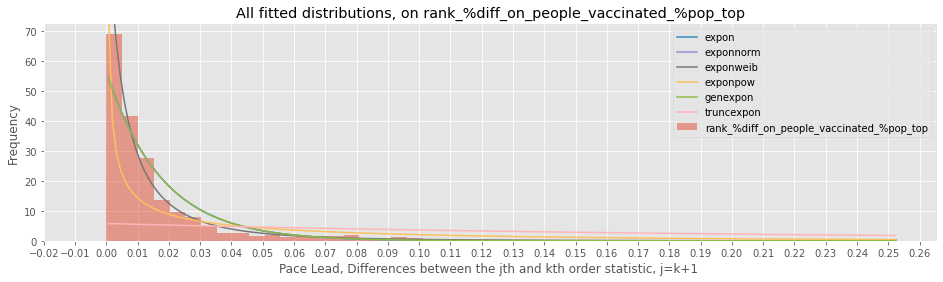

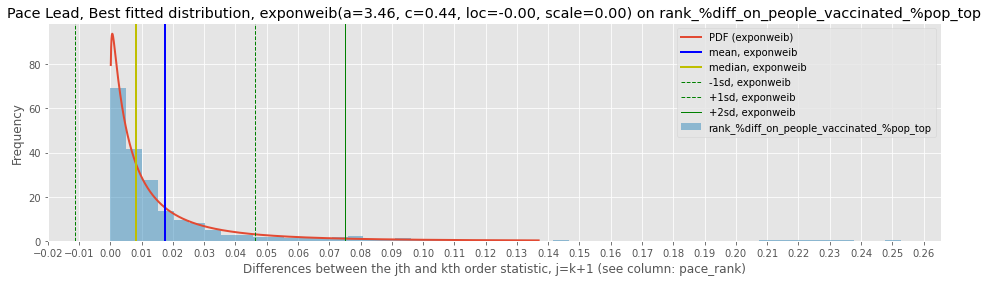

In [200]:
rank_diff_measure = 'rank_%diff_on_people_vaccinated_%pop_top'
## Compute the tops
data = leader_report[rank_diff_measure].dropna()

figsize=(16,4)
# Plot for comparison
plt.figure(figsize=figsize)
ax = data.plot(kind='hist', bins=50,  alpha=0.5, density=True,) #density=True,
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data=data, bins=200, ax=ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title('All fitted distributions, on {}'.format(rank_diff_measure))
ax.set_xlabel(u'Pace Lead, Differences between the jth and kth order statistic, j=k+1 ')
ax.set_ylabel('Frequency')
ax.legend(loc="upper right")
ax.set_xticks(np.arange(-.02, .26, .01), minor=False)


# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=figsize)
ax = pdf.plot(lw=2, label='PDF ({})'.format(best_dist.name), legend=True)
data.plot(
    kind='hist', bins=50, alpha=0.5, label=rank_diff_measure, 
    legend=True, ax=ax, density=True) # density=True,

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

a,c,loc,scale = best_fit_params
ax.set_title('Pace Lead, Best fitted distribution, {} on {}'.format(dist_str, rank_diff_measure))
ax.set_xlabel(u'Differences between the jth and kth order statistic, j=k+1 (see column: pace_rank)')
ax.set_ylabel('Frequency')
ax.axvline(best_dist.mean(a,c,loc,scale), color='b', linestyle='-', linewidth=2, label='mean, {}'.format(best_dist.name))
ax.axvline(best_dist.median(a,c,loc,scale), color='y', linestyle='-', linewidth=2, label='median, {}'.format(best_dist.name))
ax.axvline(best_dist.mean(a,c,loc,scale)-1*best_dist.std(a,c,loc,scale), color='g', linestyle='--', linewidth=1, label='-1sd, {}'.format(best_dist.name))
ax.axvline(best_dist.mean(a,c,loc,scale)+1*best_dist.std(a,c,loc,scale), color='g', linestyle='--', linewidth=1,label='+1sd, {}'.format(best_dist.name))
ax.axvline(best_dist.mean(a,c,loc,scale)+2*best_dist.std(a,c,loc,scale), color='g', linestyle='-', linewidth=1,label='+2sd, {}'.format(best_dist.name))
ax.legend(loc="upper right")
ax.set_xticks(np.arange(-.02, .26, .01), minor=False)
print(best_dist.mean(a,c,loc,scale), best_dist.std(a,c,loc,scale))

In [201]:
best_dist1 = best_dist
a1,c1,loc1,scale1 = a,c,loc,scale

0.0164605574633126 0.0235976794798801


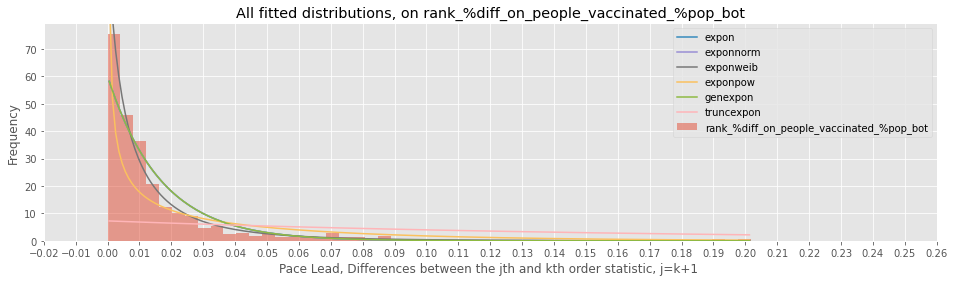

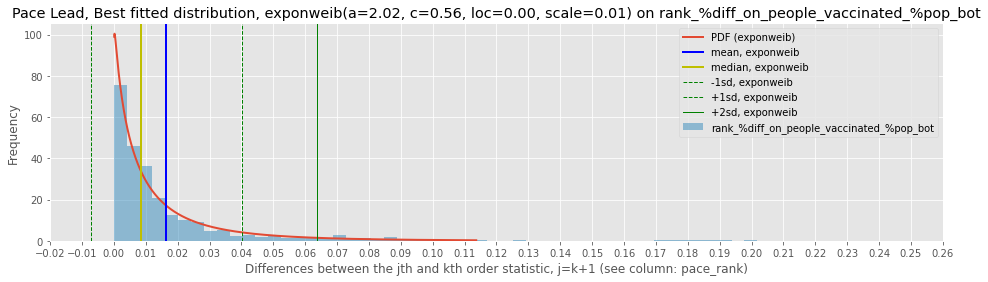

In [202]:
rank_diff_measure = 'rank_%diff_on_people_vaccinated_%pop_bot'
## Compute the tops
data = leader_report[rank_diff_measure].dropna()

figsize=(16,4)
# Plot for comparison
plt.figure(figsize=figsize)
ax = data.plot(kind='hist', bins=50,  alpha=0.5, density=True,) #density=True,
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data=data, bins=200, ax=ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title('All fitted distributions, on {}'.format(rank_diff_measure))
ax.set_xlabel(u'Pace Lead, Differences between the jth and kth order statistic, j=k+1 ')
ax.set_ylabel('Frequency')
ax.legend(loc="upper right")
ax.set_xticks(np.arange(-.02, .26, .01), minor=False)


# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=figsize)
ax = pdf.plot(lw=2, label='PDF ({})'.format(best_dist.name), legend=True)
data.plot(
    kind='hist', bins=50, alpha=0.5, label=rank_diff_measure, 
    legend=True, ax=ax, density=True) # density=True,

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title('Pace Lead, Best fitted distribution, {} on {}'.format(dist_str, rank_diff_measure))
ax.set_xlabel(u'Differences between the jth and kth order statistic, j=k+1 (see column: pace_rank)')
ax.set_ylabel('Frequency')
a,c,loc,scale = best_fit_params
ax.axvline(best_dist.mean(a,c,loc,scale), color='b', linestyle='-', linewidth=2, label='mean, {}'.format(best_dist.name))
ax.axvline(best_dist.median(a,c,loc,scale), color='y', linestyle='-', linewidth=2, label='median, {}'.format(best_dist.name))
ax.axvline(best_dist.mean(a,c,loc,scale)-1*best_dist.std(a,c,loc,scale), color='g', linestyle='--', linewidth=1, label='-1sd, {}'.format(best_dist.name))
ax.axvline(best_dist.mean(a,c,loc,scale)+1*best_dist.std(a,c,loc,scale), color='g', linestyle='--', linewidth=1,label='+1sd, {}'.format(best_dist.name))
ax.axvline(best_dist.mean(a,c,loc,scale)+2*best_dist.std(a,c,loc,scale), color='g', linestyle='-', linewidth=1,label='+2sd, {}'.format(best_dist.name))
ax.legend(loc="upper right")
ax.set_xticks(np.arange(-.02, .26, .01), minor=False)
print(best_dist.mean(a,c,loc,scale), best_dist.std(a,c,loc,scale))

In [203]:
best_dist2 = best_dist
a2,c2,loc2,scale2 = a,c,loc,scale

In [204]:
import math
#rank_%diff_on_people_vaccinated_%pop_bot
top = dict(leader_report['rank_%diff_on_{}_top'.format(pace_measure)].describe())
bot = dict(leader_report['rank_%diff_on_{}_bot'.format(pace_measure)].describe())
s1_top=top['std']
s1_bot=bot['std']

s2_top=best_dist1.std(a1,c1,loc1,scale1)
s2_bot=best_dist2.std(a2,c2,loc2,scale2)

print('ratio s1/s2 top',math.pow(s1_top,2) / math.pow(s2_top,2))
print('ratio s1/s2 bottom',math.pow(s1_bot,2) / math.pow(s2_bot,2))
print("General rule of thumb variance similar if between 1/2 < s1/s2 < 2.")

ratio s1/s2 top 1.0745183096746291
ratio s1/s2 bottom 1.1859917904974417
General rule of thumb variance similar if between 1/2 < s1/s2 < 2.


In [205]:
# TODO: look at the leads that are over 2sds from the mean
sig_sds = 3.
top_n = 5
significant_pace_leaders = {'top': {}, 'bot': {}}
sdev_to_use = s1_top,s1_bot
for pace_rank in range(1,51,1):
    significant_pace_leaders['top'][pace_rank] = leader_report[
        (leader_report['rank_%diff_on_{}_top'.format(pace_measure)] >= sig_sds*sdev_to_use[0]) 
        & (leader_report['pace_rank'] == pace_rank)]['location'].drop_duplicates().values
    
    significant_pace_leaders['bot'][pace_rank] = leader_report[
        (leader_report['rank_%diff_on_{}_bot'.format(pace_measure)] >= sig_sds*sdev_to_use[1]) 
        & (leader_report['pace_rank'] == pace_rank)]['location'].drop_duplicates().values
    
top_pace_leaders = set()
bot_pace_leaders = set()
for k,v in significant_pace_leaders['top'].items():
    if k > top_n: break
    for state in v:
        top_pace_leaders.add(state)
for k,v in significant_pace_leaders['bot'].items():
    if k < 50-top_n: continue
    for state in v:
        bot_pace_leaders.add(state)
        
print('These states held a statistically significant (+{} sds) lead AKA "pace leaders" while occuring in the top {} quickest states.'.format(sig_sds, top_n))
print(top_pace_leaders)
print()
print('These states held a statistically significant (-{} sds) lead AKA "pace laggards" while occuring in the bottom {} quickest states.'.format(sig_sds, top_n))
print(bot_pace_leaders)

These states held a statistically significant (+3.0 sds) lead AKA "pace leaders" while occuring in the top 5 quickest states.
{'Nebraska', 'West Virginia', 'Arizona', 'Alaska'}

These states held a statistically significant (-3.0 sds) lead AKA "pace laggards" while occuring in the bottom 5 quickest states.
{'District of Columbia', 'Georgia', 'Idaho'}


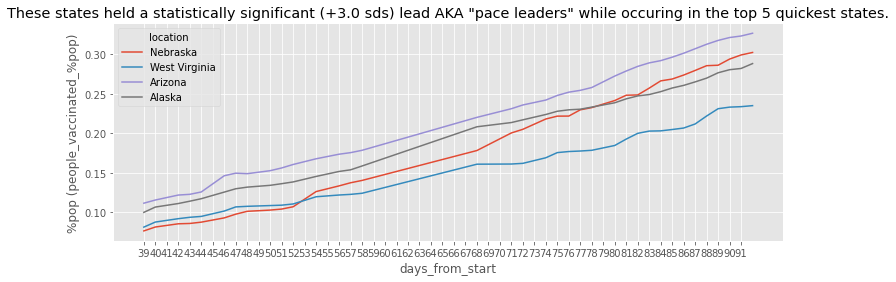

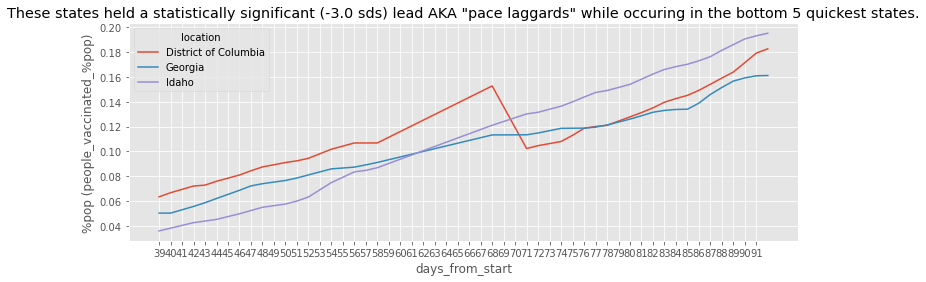

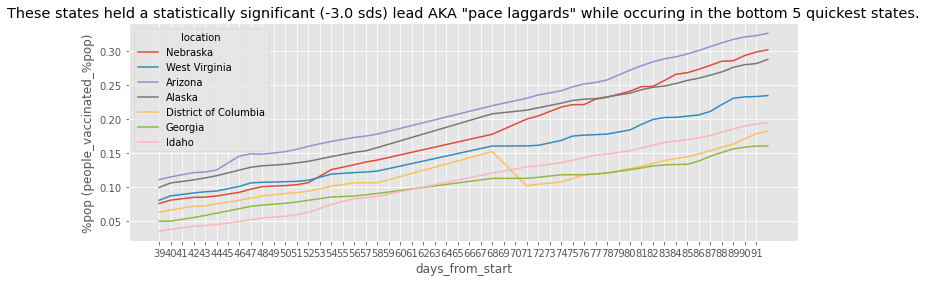

In [206]:
v_pace.dropna(how='any')[list(top_pace_leaders)].plot(
    grid=True, kind='line',figsize=(12,4),
    ylabel='%pop ({})'.format(pace_measure.replace('adj_','')), 
    xticks=list(range(v_pace.dropna(how='any').index.min(), 
                      v_pace.dropna(how='any').index.max(),1)),
    title='These states held a statistically significant (+{} sds) lead AKA "pace leaders" while occuring in the top {} quickest states.'.format(sig_sds, top_n)
)
v_pace.dropna(how='any')[bot_pace_leaders].plot(
    grid=True, kind='line',figsize=(12,4),
    ylabel='%pop ({})'.format(pace_measure.replace('adj_','')), 
    xticks=list(range(v_pace.dropna(how='any').index.min(), 
                      v_pace.dropna(how='any').index.max(),1)),
    title='These states held a statistically significant (-{} sds) lead AKA "pace laggards" while occuring in the bottom {} quickest states.'.format(sig_sds, top_n)
)
v_pace.dropna(how='any')[list(top_pace_leaders)+list(bot_pace_leaders)].plot(
    grid=True, kind='line',figsize=(12,4),
    ylabel='%pop ({})'.format(pace_measure.replace('adj_','')), 
    xticks=list(range(v_pace.dropna(how='any').index.min(), 
                      v_pace.dropna(how='any').index.max(),1)),
    title='These states held a statistically significant (-{} sds) lead AKA "pace laggards" while occuring in the bottom {} quickest states.'.format(sig_sds, top_n)
)

In [207]:
latest_adj_vax = adj_vax[
    adj_vax['date'] == adj_vax['date'].max()
][['location', 'days_from_start', pace_measure]].sort_values(pace_measure, ascending=False).copy()
latest_adj_vax['{}_shift1'.format(pace_measure)] = latest_adj_vax[pace_measure].shift(-1)
latest_adj_vax['{}_%diff_top'.format(pace_measure)] = latest_adj_vax[pace_measure] / latest_adj_vax['{}_shift1'.format(pace_measure)] -1
latest_adj_vax.index = list(range(1,len(latest_adj_vax)+1,1))

latest_adj_vax.sort_values(pace_measure, ascending=True, inplace=True)
latest_adj_vax['{}_shift1'.format(pace_measure)] = latest_adj_vax[pace_measure].shift(-1)
latest_adj_vax['{}_%diff_bot'.format(pace_measure)] = latest_adj_vax[pace_measure] / latest_adj_vax['{}_shift1'.format(pace_measure)] -1
latest_adj_vax['{}_%diff_bot'.format(pace_measure)] = latest_adj_vax['{}_%diff_bot'.format(pace_measure)].abs()

# top best_dist.std(a1,c1,loc1,scale1)
latest_adj_vax['{}_numsds_top'.format(pace_measure)] = (
    (latest_adj_vax['{}_%diff_bot'.format(pace_measure)] - best_dist1.mean(a1,c1,loc1,scale1))
     / best_dist1.std(a1,c1,loc1,scale1)
)

# bot best_dist.std(a2,c2,loc2,scale2)
latest_adj_vax['{}_numsds_bot'.format(pace_measure)] = (
    (latest_adj_vax['{}_%diff_bot'.format(pace_measure)] - best_dist2.mean(a2,c2,loc2,scale2))
     / best_dist2.std(a2,c2,loc2,scale2)
)

latest_adj_vax.sort_values(pace_measure, ascending=False, inplace=True)
latest_adj_vax

,location,days_from_start,people_vaccinated_%pop,people_vaccinated_%pop_shift1,people_vaccinated_%pop_%diff_top,people_vaccinated_%pop_%diff_bot,people_vaccinated_%pop_numsds_top,people_vaccinated_%pop_numsds_bot
1,New Hampshire,113,0.435817,NaN,0.052353,NaN,NaN,NaN
2,New Mexico,114,0.414136,0.435817,0.044107,0.049748,1.119409,1.410627
3,Connecticut,114,0.396641,0.414136,0.010218,0.042244,0.858491,1.092633
4,Maine,113,0.392629,0.396641,0.001930,0.010114,-0.258699,-0.268939
5,Massachusetts,114,0.391873,0.392629,0.023718,0.001926,-0.543405,-0.615925
6,South Dakota,113,0.382794,0.391873,0.003117,0.023169,0.195220,0.284273
7,Vermont,113,0.381604,0.382794,0.004708,0.003107,-0.502346,-0.565885
8,New Jersey,113,0.379816,0.381604,0.024360,0.004686,-0.447449,-0.498978
9,Rhode Island,114,0.370784,0.379816,0.037944,0.023781,0.216513,0.310223
10,Wisconsin,113,0.357229,0.370784,0.000309,0.036557,0.660729,0.851611


For basic vaccinations (once), we learned that as of Mar 31 2021 in any state, New Mexico has vaccinated the largest percentage of its population, the top 3 most vaccinated being New Mexico, New Hampshire and Connecticut.  All of them are on day 108 or 109 of their vaccine distribution campaigns.  As far as pace leads go, none of the top 3 hold a statistically significant lead.  The slowest 3 states were Alabama, Georgia and Mississipi, and none of those significantly slower than the other.  We're finding that it is unusual to see a lead of more than about 7.1% and to lag by more than 7.2% between states in the pace leaderboard.  In the future, we may expand our definition of statistical significance to compare between non-adjacent states.

### Looking at a different measure of success (full vaccination)

In [208]:
pace_measure = 'people_fully_vaccinated_%pop'
v_pace = dod_adj_vax[~dod_adj_vax['is_cdc_start']][['days_from_start','location',pace_measure]].pivot(
    index='days_from_start', columns=['location'], values=pace_measure
)

In [209]:
pace_top3 = {}
pace_bot3 = {}

# Compares only states before the cdc policy change, after vs after.
leader_report = []
for (cohort,date), data in dod_adj_vax[~dod_adj_vax['is_cdc_start']].groupby(['is_before_cdc','days_from_start']):
    # ignoring days where some of the observed measure values are null
    if not data[pd.isnull(data[pace_measure])].empty: continue
        
    # looks only at days where all states were in one cohort or the other (before cdc; after cdc)
    if len(data) < 50: continue
    
    tmp = data.sort_values(pace_measure, ascending=False)
    pace_top3[(cohort,date)] = tmp[-3:].location.values
    pace_bot3[(cohort,date)] = tmp[:3].location.values
    
    tmp['pace_rank'] = list(range(1,len(tmp)+1))
    tmp['shift1'] = tmp[pace_measure].shift(-1)
    tmp['rank_%diff_on_{}_top'.format(pace_measure)] = (tmp[pace_measure] / tmp['shift1']) - 1
    del tmp['shift1']
    
    tmp = tmp.sort_values(pace_measure, ascending=True)
    tmp['shift1'] = tmp[pace_measure].shift(-1)
    tmp['rank_%diff_on_{}_bot'.format(pace_measure)] = (tmp[pace_measure] / tmp['shift1']) - 1
    tmp['rank_%diff_on_{}_bot'.format(pace_measure)] = tmp['rank_%diff_on_{}_bot'.format(pace_measure)].abs()
    
    del tmp['shift1']
    leader_report.append(tmp)
    del tmp
    
leader_report = pd.concat(leader_report,axis=0)

0.02765825349332718 0.03862206276057164


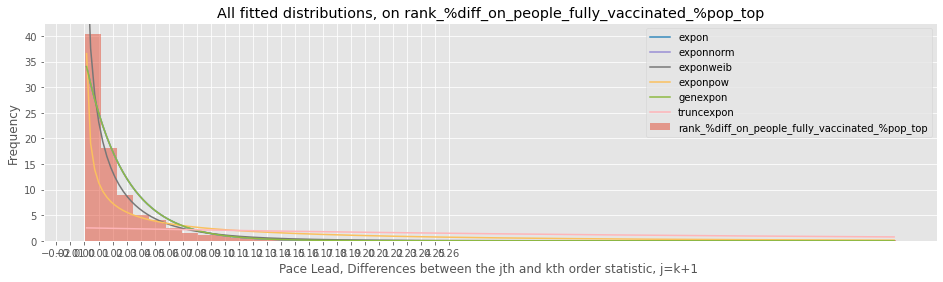

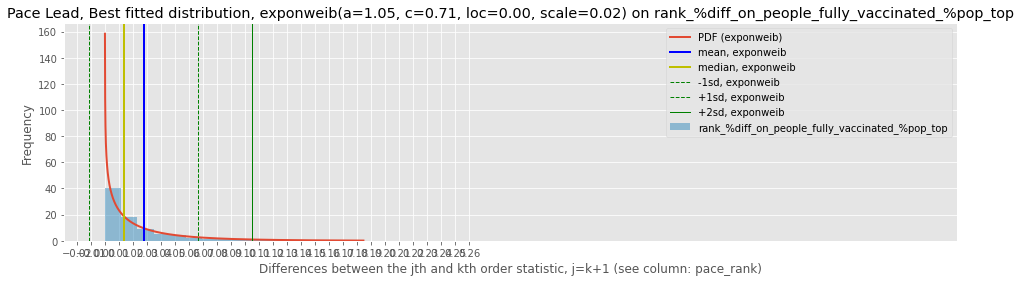

In [210]:
rank_diff_measure = 'rank_%diff_on_{}_top'.format(pace_measure)
## Compute the tops
data = leader_report[rank_diff_measure].dropna()

figsize=(16,4)
# Plot for comparison
plt.figure(figsize=figsize)
ax = data.plot(kind='hist', bins=50,  alpha=0.5, density=True,) #density=True,
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data=data, bins=200, ax=ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title('All fitted distributions, on {}'.format(rank_diff_measure))
ax.set_xlabel(u'Pace Lead, Differences between the jth and kth order statistic, j=k+1 ')
ax.set_ylabel('Frequency')
ax.legend(loc="upper right")
ax.set_xticks(np.arange(-.02, .26, .01), minor=False)


# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=figsize)
ax = pdf.plot(lw=2, label='PDF ({})'.format(best_dist.name), legend=True)
data.plot(
    kind='hist', bins=50, alpha=0.5, label=rank_diff_measure, 
    legend=True, ax=ax, density=True) # density=True,

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

a,c,loc,scale = best_fit_params
ax.set_title('Pace Lead, Best fitted distribution, {} on {}'.format(dist_str, rank_diff_measure))
ax.set_xlabel(u'Differences between the jth and kth order statistic, j=k+1 (see column: pace_rank)')
ax.set_ylabel('Frequency')
ax.axvline(best_dist.mean(a,c,loc,scale), color='b', linestyle='-', linewidth=2, label='mean, {}'.format(best_dist.name))
ax.axvline(best_dist.median(a,c,loc,scale), color='y', linestyle='-', linewidth=2, label='median, {}'.format(best_dist.name))
ax.axvline(best_dist.mean(a,c,loc,scale)-1*best_dist.std(a,c,loc,scale), color='g', linestyle='--', linewidth=1, label='-1sd, {}'.format(best_dist.name))
ax.axvline(best_dist.mean(a,c,loc,scale)+1*best_dist.std(a,c,loc,scale), color='g', linestyle='--', linewidth=1,label='+1sd, {}'.format(best_dist.name))
ax.axvline(best_dist.mean(a,c,loc,scale)+2*best_dist.std(a,c,loc,scale), color='g', linestyle='-', linewidth=1,label='+2sd, {}'.format(best_dist.name))
ax.legend(loc="upper right")
ax.set_xticks(np.arange(-.02, .26, .01), minor=False)
print(best_dist.mean(a,c,loc,scale), best_dist.std(a,c,loc,scale))

In [211]:
best_dist3 = best_dist
a3,c3,loc3,scale3 = a,c,loc,scale

0.024707748191602666 0.034586576515242745


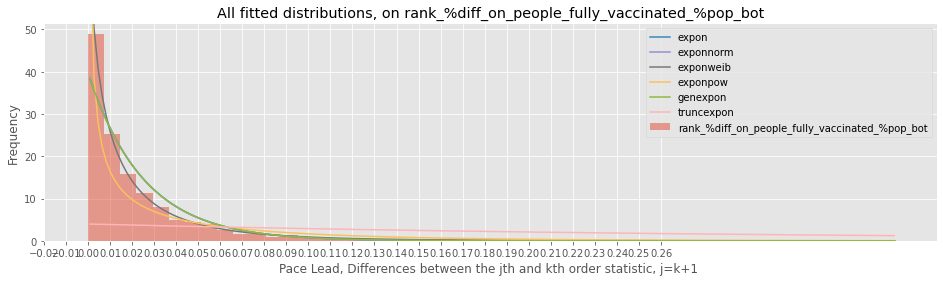

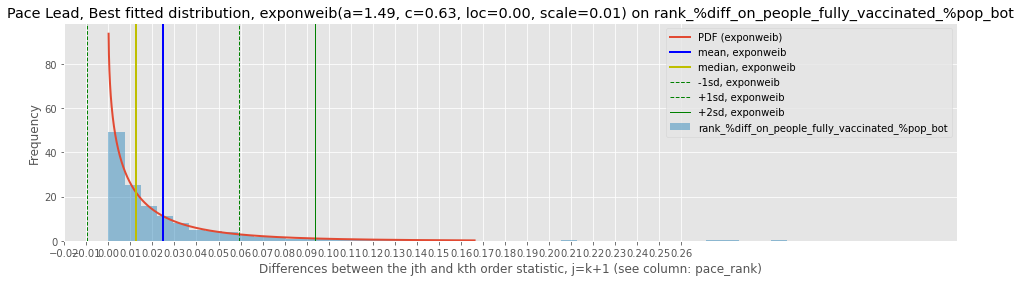

In [212]:
rank_diff_measure = 'rank_%diff_on_{}_bot'.format(pace_measure)
## Compute the tops
data = leader_report[rank_diff_measure].dropna()

figsize=(16,4)
# Plot for comparison
plt.figure(figsize=figsize)
ax = data.plot(kind='hist', bins=50,  alpha=0.5, density=True,) #density=True,
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data=data, bins=200, ax=ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title('All fitted distributions, on {}'.format(rank_diff_measure))
ax.set_xlabel(u'Pace Lead, Differences between the jth and kth order statistic, j=k+1 ')
ax.set_ylabel('Frequency')
ax.legend(loc="upper right")
ax.set_xticks(np.arange(-.02, .26, .01), minor=False)


# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=figsize)
ax = pdf.plot(lw=2, label='PDF ({})'.format(best_dist.name), legend=True)
data.plot(
    kind='hist', bins=50, alpha=0.5, label=rank_diff_measure, 
    legend=True, ax=ax, density=True) # density=True,

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

a,c,loc,scale = best_fit_params
ax.set_title('Pace Lead, Best fitted distribution, {} on {}'.format(dist_str, rank_diff_measure))
ax.set_xlabel(u'Differences between the jth and kth order statistic, j=k+1 (see column: pace_rank)')
ax.set_ylabel('Frequency')
ax.axvline(best_dist.mean(a,c,loc,scale), color='b', linestyle='-', linewidth=2, label='mean, {}'.format(best_dist.name))
ax.axvline(best_dist.median(a,c,loc,scale), color='y', linestyle='-', linewidth=2, label='median, {}'.format(best_dist.name))
ax.axvline(best_dist.mean(a,c,loc,scale)-1*best_dist.std(a,c,loc,scale), color='g', linestyle='--', linewidth=1, label='-1sd, {}'.format(best_dist.name))
ax.axvline(best_dist.mean(a,c,loc,scale)+1*best_dist.std(a,c,loc,scale), color='g', linestyle='--', linewidth=1,label='+1sd, {}'.format(best_dist.name))
ax.axvline(best_dist.mean(a,c,loc,scale)+2*best_dist.std(a,c,loc,scale), color='g', linestyle='-', linewidth=1,label='+2sd, {}'.format(best_dist.name))
ax.legend(loc="upper right")
ax.set_xticks(np.arange(-.02, .26, .01), minor=False)
print(best_dist.mean(a,c,loc,scale), best_dist.std(a,c,loc,scale))

In [213]:
best_dist4 = best_dist
a4,c4,loc4,scale4 = a,c,loc,scale

In [214]:
import math
top = dict(leader_report['rank_%diff_on_{}_top'.format(pace_measure)].describe())
bot = dict(leader_report['rank_%diff_on_{}_bot'.format(pace_measure)].describe())
s1_top=top['std']
s1_bot=bot['std']

s2_top=best_dist3.std(a3,c3,loc3,scale3)
s2_bot=best_dist4.std(a4,c4,loc4,scale4)

print('ratio s1/s2 top',math.pow(s1_top,2) / math.pow(s2_top,2))
print('ratio s1/s2 bottom',math.pow(s1_bot,2) / math.pow(s2_bot,2))
print("General rule of thumb similar if between 1/2 < s1/s2 < 2.")

ratio s1/s2 top 1.8187359008657167
ratio s1/s2 bottom 1.3037149184295125
General rule of thumb similar if between 1/2 < s1/s2 < 2.


In [215]:
# TODO: look at the leads that are over 2sds from the mean
sig_sds = 3.
top_n = 5
significant_pace_leaders = {'top': {}, 'bot': {}}
sdev_to_use = s1_top,s1_bot
for pace_rank in range(1,51,1):
    significant_pace_leaders['top'][pace_rank] = leader_report[
        (leader_report['rank_%diff_on_{}_top'.format(pace_measure)] >= sig_sds*sdev_to_use[0]) 
        & (leader_report['pace_rank'] == pace_rank)]['location'].drop_duplicates().values
    
    significant_pace_leaders['bot'][pace_rank] = leader_report[
        (leader_report['rank_%diff_on_{}_bot'.format(pace_measure)] >= sig_sds*sdev_to_use[1]) 
        & (leader_report['pace_rank'] == pace_rank)]['location'].drop_duplicates().values
    
top_pace_leaders = set()
bot_pace_leaders = set()
for k,v in significant_pace_leaders['top'].items():
    if k > top_n: break
    for state in v:
        top_pace_leaders.add(state)
for k,v in significant_pace_leaders['bot'].items():
    if k < 50-top_n: continue
    for state in v:
        bot_pace_leaders.add(state)
        
print('These states held a statistically significant (+{} sds) lead AKA "pace leaders" while occuring in the top {} quickest states.'.format(sig_sds, top_n))
print(top_pace_leaders)
print()
print('These states held a statistically significant (-{} sds) lead AKA "pace laggards" while occuring in the bottom {} quickest states.'.format(sig_sds, top_n))
print(bot_pace_leaders)

These states held a statistically significant (+3.0 sds) lead AKA "pace leaders" while occuring in the top 5 quickest states.
{'West Virginia', 'Alaska', 'Nebraska'}

These states held a statistically significant (-3.0 sds) lead AKA "pace laggards" while occuring in the bottom 5 quickest states.
{'District of Columbia', 'Alabama', 'Mississippi'}


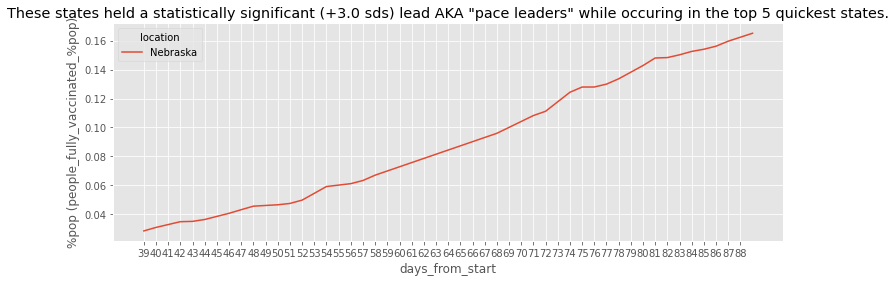

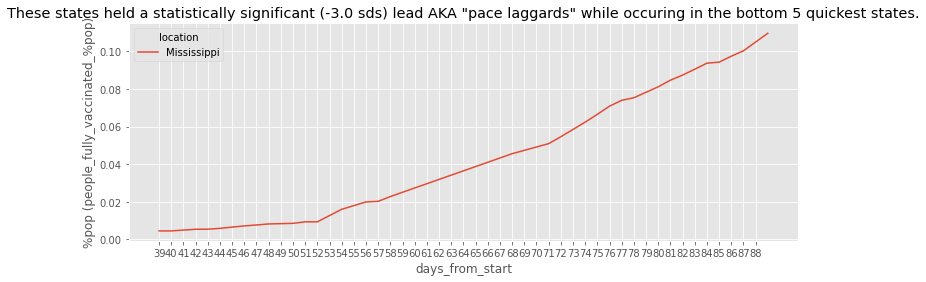

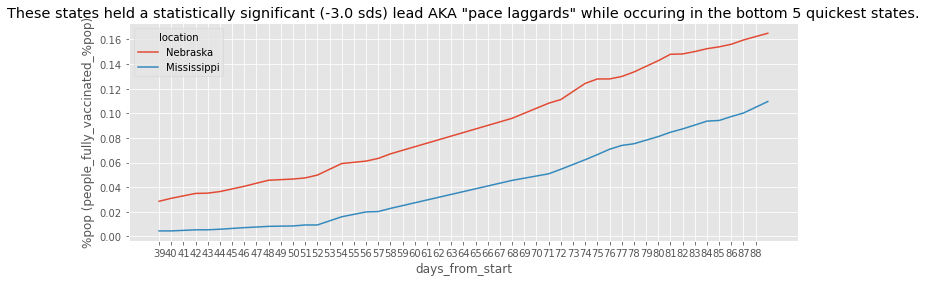

In [45]:
v_pace.dropna(how='any')[list(top_pace_leaders)].plot(
    grid=True, kind='line',figsize=(12,4),
    ylabel='%pop ({})'.format(pace_measure.replace('adj_','')), 
    xticks=list(range(v_pace.dropna(how='any').index.min(), 
                      v_pace.dropna(how='any').index.max(),1)),
    title='These states held a statistically significant (+{} sds) lead AKA "pace leaders" while occuring in the top {} quickest states.'.format(sig_sds, top_n)
)
v_pace.dropna(how='any')[bot_pace_leaders].plot(
    grid=True, kind='line',figsize=(12,4),
    ylabel='%pop ({})'.format(pace_measure.replace('adj_','')), 
    xticks=list(range(v_pace.dropna(how='any').index.min(), 
                      v_pace.dropna(how='any').index.max(),1)),
    title='These states held a statistically significant (-{} sds) lead AKA "pace laggards" while occuring in the bottom {} quickest states.'.format(sig_sds, top_n)
)
v_pace.dropna(how='any')[list(top_pace_leaders)+list(bot_pace_leaders)].plot(
    grid=True, kind='line',figsize=(12,4),
    ylabel='%pop ({})'.format(pace_measure.replace('adj_','')), 
    xticks=list(range(v_pace.dropna(how='any').index.min(), 
                      v_pace.dropna(how='any').index.max(),1)),
    title='These states held a statistically significant (-{} sds) lead AKA "pace laggards" while occuring in the bottom {} quickest states.'.format(sig_sds, top_n)
)

In [221]:
pace_measure

'people_fully_vaccinated_%pop'

In [230]:
pace_measure = "people_fully_vaccinated_%pop"
latest_adj_vax = adj_vax[
    adj_vax['date'] == adj_vax['date'].max()
][['date', 'location', 'days_from_start', pace_measure]].sort_values(pace_measure, ascending=False).copy()
latest_adj_vax['{}_shift1'.format(pace_measure)] = latest_adj_vax[pace_measure].shift(-1)
latest_adj_vax['{}_%diff_top'.format(pace_measure)] = latest_adj_vax[pace_measure] / latest_adj_vax['{}_shift1'.format(pace_measure)] -1
latest_adj_vax.index = list(range(1,len(latest_adj_vax)+1,1))

latest_adj_vax.sort_values(pace_measure, ascending=True, inplace=True)
latest_adj_vax['{}_shift1'.format(pace_measure)] = latest_adj_vax[pace_measure].shift(-1)
latest_adj_vax['{}_%diff_bot'.format(pace_measure)] = latest_adj_vax[pace_measure] / latest_adj_vax['{}_shift1'.format(pace_measure)] -1
latest_adj_vax['{}_%diff_bot'.format(pace_measure)] = latest_adj_vax['{}_%diff_bot'.format(pace_measure)].abs()

del latest_adj_vax['{}_shift1'.format(pace_measure)]

# top best_dist.std(a1,c1,loc1,scale1)
latest_adj_vax['{}_numsds_top'.format(pace_measure)] = (
    (latest_adj_vax['{}_%diff_bot'.format(pace_measure)] - best_dist3.mean(a3,c3,loc3,scale3))
     / best_dist3.std(a3,c3,loc3,scale3)
)

# bot best_dist.std(a2,c2,loc2,scale2)
latest_adj_vax['{}_numsds_bot'.format(pace_measure)] = (
    (latest_adj_vax['{}_%diff_bot'.format(pace_measure)] - best_dist4.mean(a4,c4,loc4,scale4))
     / best_dist4.std(a4,c4,loc4,scale4)
)

latest_adj_vax.sort_values(pace_measure, ascending=False, inplace=True)
print('As of:', adj_vax['date'].max())
latest_adj_vax[['location', 'days_from_start', pace_measure]][-10:]

As of: 2021-04-07 00:00:00


,location,days_from_start,people_fully_vaccinated_%pop
42,Missouri,106,0.179472
43,Mississippi,114,0.173185
44,South Carolina,114,0.172384
45,Texas,114,0.169426
46,Arkansas,114,0.166780
47,District of Columbia,114,0.161803
48,Tennessee,112,0.160400
49,Alabama,113,0.151934
50,Utah,112,0.141542
51,Georgia,113,0.140757


We notice that the leaders in vaccination change when we look at the percent of population fully vaccinated vs percent of population vaccinated at least once.  While New Hampshire and Connecticut have been very good at vaccinating people at least once, they have not done as well vaccinating people to completion.  Especially in the case of New Hampshire which has been 2nd best at vaccinating at least once, but is 22nd at vaccinating to completion.  The laggards also change.   For example, Mississippi is 3rd slowest in the country to vaccinate its population at least once, but it is only 8th slowest to vaccinate to completion.  Other notable shifts include Washington D.C. which is not so bad, only 15th worst at vaccinating at least once, but is 5th worst at vaccinating to completion.  For sure, the most extreme contrast is with New Hampshire, which is excellent at vaccinating once, but just ok at vaccinating to completion.

## Which states saw the biggest, smallest, average impact of vaccination on reducing new cases?  Statistically significant?
This is really where the vaccine should see it's big impact.  The claim is that the vaccines Moderna and Phizer are 90% effective in preventing the vaccine.  So we will just chart the percent of the population that has been fully vaccinated against the number of new cases.  We hope to see a noticeable reduction.  We may look at the states that have been most effective at vaccinating to completion, so New Mexico, South Dakota and Alaska.  However all of the top 3 in this case have a low population density.   Connecticut and New Jersey may be good examples to look at because they've done well at fully vaccinating their population and are relatively densely populated and active.

Solution Design:
1. Join the cvd dataset from nytimes with the adj_vax dataset. We want a right join so we keep the index from cvd, and add in the observations from adj_vax
2. Looking at columns: 'cases' from nytimes and `people_fully_vaccinated_%pop` from OWID

### Accounting for existing herd-immunity
According to Susan Hopkins of the SIREN study hosted in Public Health England in London [summarized in Nature, (14 Jan 2021)](https://www.nature.com/articles/d41586-021-00071-6), having had covid-19 makes it virtually impossible one will get it for several months. Right or wrong, people who had already had covid and fought it off would be less likely to get the vaccination.  I have heard mixed conclusions whether having had covid actually risk of getting it again.  

In [48]:
cvd_and_vax = pd.merge(
    left=cvd.df, right=adj_vax, 
    how='left', left_on=['date', 'state'], 
    right_on=['date', 'location']
).copy()
cvd_and_vax[['total_vaccinations', 'total_distributed', 'people_vaccinated',
       'people_fully_vaccinated_per_hundred', 'total_vaccinations_per_hundred',
       'people_fully_vaccinated', 'people_vaccinated_per_hundred',
       'distributed_per_hundred', 'daily_vaccinations_raw',
       'daily_vaccinations', 'daily_vaccinations_per_million',
       'share_doses_used']] = cvd_and_vax[['total_vaccinations', 'total_distributed', 'people_vaccinated',
       'people_fully_vaccinated_per_hundred', 'total_vaccinations_per_hundred',
       'people_fully_vaccinated', 'people_vaccinated_per_hundred',
       'distributed_per_hundred', 'daily_vaccinations_raw',
       'daily_vaccinations', 'daily_vaccinations_per_million',
       'share_doses_used']].fillna(0.,)

cvd_and_vax.dropna(subset=['state'])
del cvd_and_vax['location']

cvd_and_vax['cases_%pop'] = cvd_and_vax.apply(
    lambda x: compute_fn(
        a=x['cases'],
        b=apply_dic(state_to_pop, x['state']),
        fn=lambda a,b: a/b),
    axis=1
)
cvd_and_vax['deaths_%pop'] = cvd_and_vax.apply(
    lambda x: compute_fn(
        a=x['deaths'],
        b=apply_dic(state_to_pop, x['state']),
        fn=lambda a,b: a/b),
    axis=1
)
cvd_and_vax.index = cvd_and_vax['date']

### state-level calcs ###
# an adjusted population measurement accounting for people who have been immunized and 
# we have a challenge adjusting the population because if we adjust by deaths and cases, we are double counting
# this is a cost of having aggregated non-subject level data sets.  It's impossible to know how to account for 
# the cases and deaths in a harmonious way
# - increase people_immd by people_fully_immunized on (t-vax_imm_lag) days ago
# - increase people_immd by cases on (t-case_incub_pd) days ago
# - decrease people_immd by cases that happened more than case_imty_pd*30 days ago
# - don't do anything with deaths because not that many people have died in the grand scheme

vax_imm_lag = 14 # vaccinated people are immune starting X days after the fully vaccinated
case_incub_pd = 10 # days between people contract covid-19 and  start being symptomatic
case_imty_pd = 4 # months after a person has covid, they can get it again

state_level_cvd_and_vax = []
for state, data in cvd_and_vax.groupby('state'):
    tmp = data.copy()
    tmp['new_daily_cases'] = tmp['cases'] - tmp['cases'].shift(1)
    tmp['new_daily_deaths'] = tmp['deaths'] - tmp['deaths'].shift(1)
    tmp['people_fully_vaccinated_%pop_immLagAgo'] = tmp['people_fully_vaccinated_%pop'].shift(vax_imm_lag)
    tmp['new_daily_people_fully_vaccinated'] = tmp['people_fully_vaccinated'] - tmp['people_fully_vaccinated'].shift(1)

    
    tmp['people_immd'] = \
        tmp['new_daily_cases'].shift(case_incub_pd) \
        + tmp['people_fully_vaccinated_%pop_immLagAgo'] \
        - tmp['new_daily_cases'].shift(case_imty_pd*30)

    tmp['people_immd_%pop'] = tmp.apply(
        lambda x: compute_fn(
            a=x['people_immd'],
            b=apply_dic(state_to_pop, x['state']),
            fn=lambda a,b: a/b),
        axis=1
    )
    
    state_level_cvd_and_vax.append(tmp)

state_level_cvd_and_vax = pd.concat(state_level_cvd_and_vax, axis=0)
state_level_cvd_and_vax['new_daily_cases_%pop'] = state_level_cvd_and_vax.apply(
    lambda x: compute_fn(
        a=x['new_daily_cases'],
        b=apply_dic(state_to_pop, x['state']),
        fn=lambda a,b: a/b),
    axis=1
)
state_level_cvd_and_vax['new_daily_deaths_%pop'] = state_level_cvd_and_vax.apply(
    lambda x: compute_fn(
        a=x['new_daily_deaths'],
        b=apply_dic(state_to_pop, x['state']),
        fn=lambda a,b: a/b),
    axis=1
)

# compute vulnerable population which is the (census "POP" - people_immd)
state_level_cvd_and_vax['vpop'] = state_level_cvd_and_vax.apply(
    lambda x: compute_fn(
        a=apply_dic(state_to_pop, x['state']),
        b=x['people_immd'],
        fn=lambda a,b: a-b),
    axis=1
)

state_level_cvd_and_vax['new_daily_cases_%vpop'] = state_level_cvd_and_vax.apply(
    lambda x: compute_fn(
        a=x['new_daily_cases'],
        b=x['vpop'],
        fn=lambda a,b: a/b),
    axis=1
)
state_level_cvd_and_vax['new_daily_deaths_%vpop'] = state_level_cvd_and_vax.apply(
    lambda x: compute_fn(
        a=x['new_daily_deaths'],
        b=apply_dic(state_to_pop, x['state']),
        fn=lambda a,b: a/b),
    axis=1
)

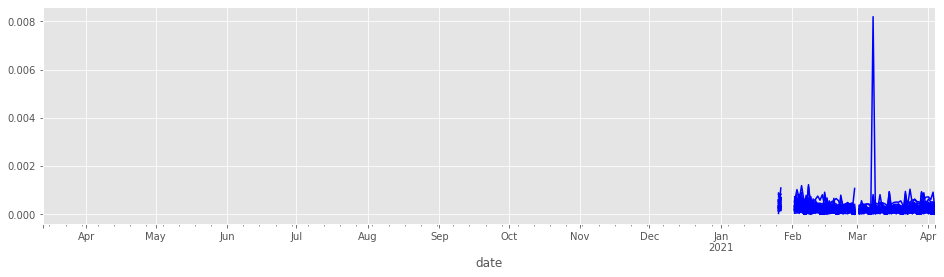

In [51]:
for state, state_cvdvax in state_level_cvd_and_vax.groupby(['state']):
    state_cvdvax['new_daily_cases_%vpop'].plot(kind='line', style='b-', figsize=figsize)
    state_cvdvax['people_vaccinated_%pop'].plot(kind='line', style='r--', secondary_y=True, ax=ax)

In [52]:

from scipy.optimize import curve_fit
from scipy.stats import linregress
    
def do_linregress(df, xcol, ycol):
    linfn = lambda x,a,b: a*x+b
    expdata = df.dropna(subset=[xcol, ycol], how='any').copy()
    return linregress(
        x=expdata[xcol],
        y=expdata[ycol]
)
    
def do_linfit(df, xcol, ycol):
    linfn = lambda x,a,b: a*x+b
    expdata = df.dropna(subset=[xcol, ycol], how='any').copy()
    popt, pcov = curve_fit(linfn,  expdata[xcol],  expdata[ycol])
    r = expdata[ycol] - linfn(expdata[ycol], *popt)
    ss_res = np.sum(r**2)
    ss_tot = np.sum((expdata[ycol]-np.mean(expdata[ycol]))**2)
    rsq = 1 - (ss_res / ss_tot)
    
    return linfn,popt,pcov,rsq

def do_linregress(df, xcol, ycol):
    linfn = lambda x,a,b: a*x+b
    expdata = df.dropna(subset=[xcol, ycol], how='any').copy()
    return linregress(
        x=expdata[xcol],
        y=expdata[ycol]
    )
    


In [53]:
print(do_linfit(
    df=state_level_cvd_and_vax, 
    xcol='people_fully_vaccinated_%pop_immLagAgo', 
    ycol='new_daily_cases_%vpop'
))
print(do_linregress(
    df=state_level_cvd_and_vax, 
    xcol='people_fully_vaccinated_%pop_immLagAgo', 
    ycol='new_daily_cases_%vpop'
))

(<function do_linfit.<locals>.<lambda> at 0x7fbcf0fcebf8>, array([-0.0008669 ,  0.00026001]), array([[ 6.48905475e-09, -3.76365825e-10],
       [-3.76365825e-10,  3.43743888e-11]]), -0.061157391838227104)
LinregressResult(slope=-0.0008668985886382586, intercept=0.00026001055322262426, rvalue=-0.1854676270522891, pvalue=1.4560878061015604e-26, stderr=8.055466944493396e-05)


Assumption: immLag = 14: days after second vaccination for immunity


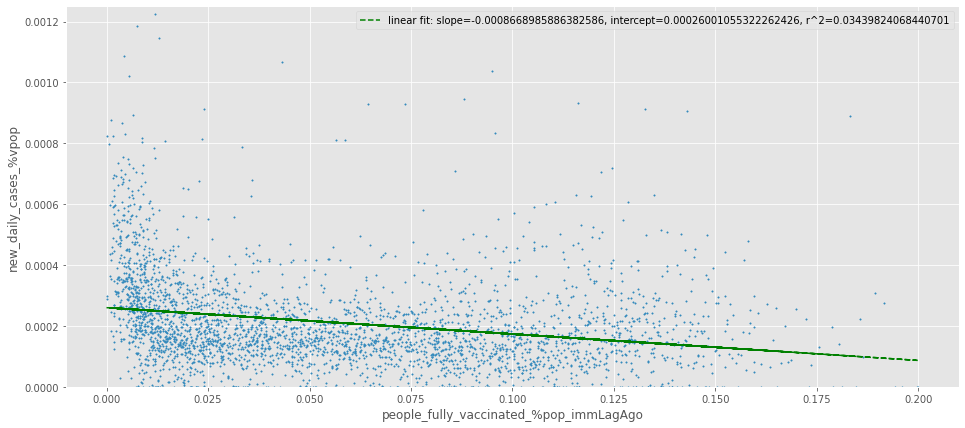

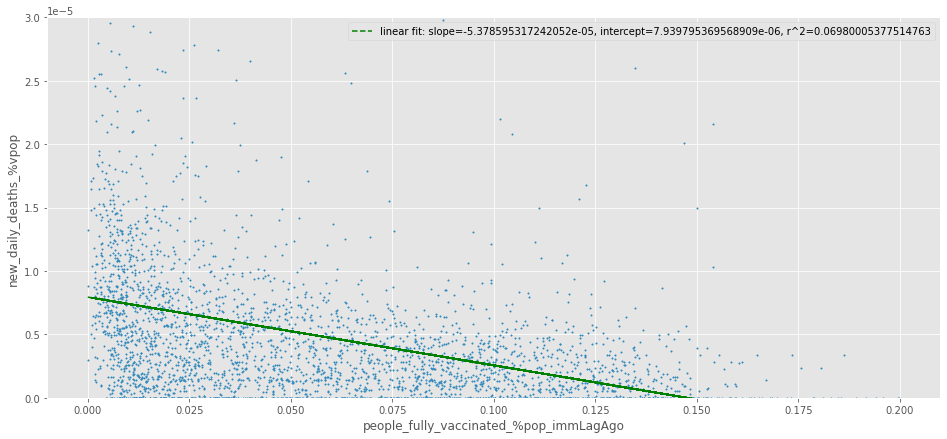

In [55]:
ax1 = state_level_cvd_and_vax.plot.scatter(
    x='people_fully_vaccinated_%pop_immLagAgo', y='new_daily_cases_%vpop', figsize=(16,7), s=2)

cases_reg = do_linregress(
    df=state_level_cvd_and_vax, 
    xcol='people_fully_vaccinated_%pop_immLagAgo', 
    ycol='new_daily_cases_%vpop'
)
plt.plot(
    state_level_cvd_and_vax['people_fully_vaccinated_%pop_immLagAgo'], 
    state_level_cvd_and_vax['people_fully_vaccinated_%pop_immLagAgo']*cases_reg.slope+cases_reg.intercept,
    'g--', label='linear fit: slope={}, intercept={}, r^2={}'.format(cases_reg.slope,cases_reg.intercept,math.pow(cases_reg.rvalue,2)))
ax1.legend(loc="upper right")

ax2 = state_level_cvd_and_vax.plot.scatter(
    x='people_fully_vaccinated_%pop_immLagAgo', y='new_daily_deaths_%vpop', figsize=(16,7), s=2)

deaths_reg = do_linregress(
    df=state_level_cvd_and_vax, 
    xcol='people_fully_vaccinated_%pop_immLagAgo', 
    ycol='new_daily_deaths_%vpop'
)
plt.plot(
    state_level_cvd_and_vax['people_fully_vaccinated_%pop_immLagAgo'], 
    state_level_cvd_and_vax['people_fully_vaccinated_%pop_immLagAgo']*deaths_reg.slope+deaths_reg.intercept,
    'g--', label='linear fit: slope={}, intercept={}, r^2={}'.format(deaths_reg.slope,deaths_reg.intercept,math.pow(deaths_reg.rvalue,2)))
ax2.legend(loc="upper right")

ax1.set_ylim(0.,.00125)
ax2.set_ylim(0.,.00003)
print('Assumption: immLag = {}: days after second vaccination for immunity'.format(vax_imm_lag))

In [ ]:
vax_imm_lag = 14 # vaccinated people are immune starting X days after the fully vaccinated
case_incub_pd = 10 # days between people contract covid-19 and  start being symptomatic
case_imty_pd = 4 # months after a person has covid, they can get it again

### Looking at Vaccination Pace Leaders and Laggards in terms of Efficacy
Using the tool we built to look at the impact of vaccinations on new cases, we will examine some of the states that were noted as being very good at vaccinating, and very bad.
#### New Mexico: Most vaccinated state to-date

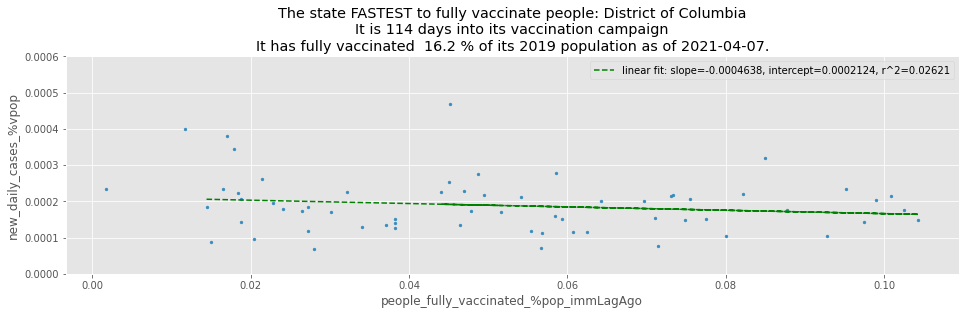

In [232]:
most_vaxed = latest_adj_vax.iloc[-5]
most_vaxed_state_data = state_level_cvd_and_vax[state_level_cvd_and_vax['state'] == most_vaxed.location].copy()

# cases
ax1 = most_vaxed_state_data.plot.scatter(
    x='people_fully_vaccinated_%pop_immLagAgo', y='new_daily_cases_%vpop', figsize=(16,4), s=8)

most_cases_reg = do_linregress(
    df=most_vaxed_state_data, 
    xcol='people_fully_vaccinated_%pop_immLagAgo', 
    ycol='new_daily_cases_%vpop'
)
plt.plot(
    most_vaxed_state_data['people_fully_vaccinated_%pop_immLagAgo'], 
    most_vaxed_state_data['people_fully_vaccinated_%pop_immLagAgo']*most_cases_reg.slope+most_cases_reg.intercept,
    'g--', label='linear fit: slope={:3.4}, intercept={:3.4}, r^2={:3.4}'.format(
        most_cases_reg.slope,most_cases_reg.intercept,math.pow(most_cases_reg.rvalue,2)))
ax1.legend(loc="upper right")

ax1.set_ylim(0.,.0006)

title = "\n".join([
    "The state FASTEST to fully vaccinate people: {}",
    "It is {} days into its vaccination campaign",
    "It has fully vaccinated {:5.3} % of its 2019 population as of {}."]).format(
    most_vaxed.location, most_vaxed.days_from_start, most_vaxed['people_fully_vaccinated_%pop']*100, most_vaxed.date.date())
ax1.set_title(title)
print()

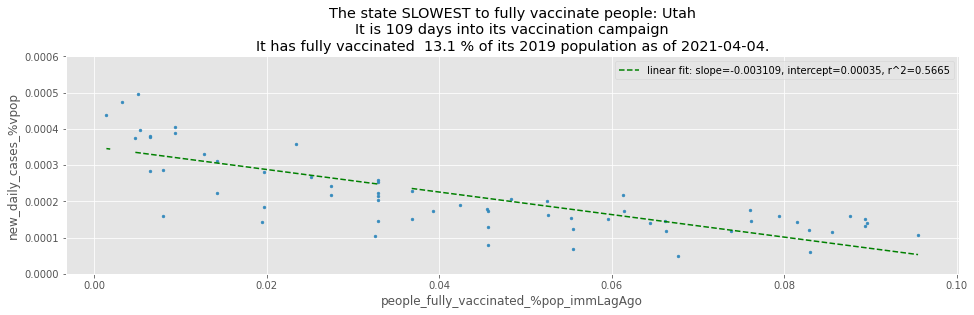

In [106]:
least_vaxed = latest_adj_vax.iloc[-1]
least_vaxed_state_data = state_level_cvd_and_vax[state_level_cvd_and_vax['state'] == least_vaxed.location].copy()

# cases
ax1 = least_vaxed_state_data.plot.scatter(
    x='people_fully_vaccinated_%pop_immLagAgo', y='new_daily_cases_%vpop', figsize=(16,4), s=8)

least_cases_reg = do_linregress(
    df=least_vaxed_state_data, 
    xcol='people_fully_vaccinated_%pop_immLagAgo', 
    ycol='new_daily_cases_%vpop'
)
plt.plot(
    least_vaxed_state_data['people_fully_vaccinated_%pop_immLagAgo'], 
    least_vaxed_state_data['people_fully_vaccinated_%pop_immLagAgo']*least_cases_reg.slope+least_cases_reg.intercept,
    'g--', label='linear fit: slope={:3.4}, intercept={:3.4}, r^2={:3.4}'.format(
        least_cases_reg.slope,least_cases_reg.intercept,math.pow(least_cases_reg.rvalue,2)))
ax1.legend(loc="upper right")

ax1.set_ylim(0.,.0006)

title = "\n".join([
    "The state SLOWEST to fully vaccinate people: {}",
    "It is {} days into its vaccination campaign",
    "It has fully vaccinated {:5.3} % of its 2019 population as of {}."]).format(
    least_vaxed.location, least_vaxed.days_from_start, least_vaxed['people_fully_vaccinated_%pop']*100, least_vaxed.date.date())
ax1.set_title(title)
# print('Assumption: immLag = {}: days after second vaccination for immunity'.format(vax_imm_lag))
print()

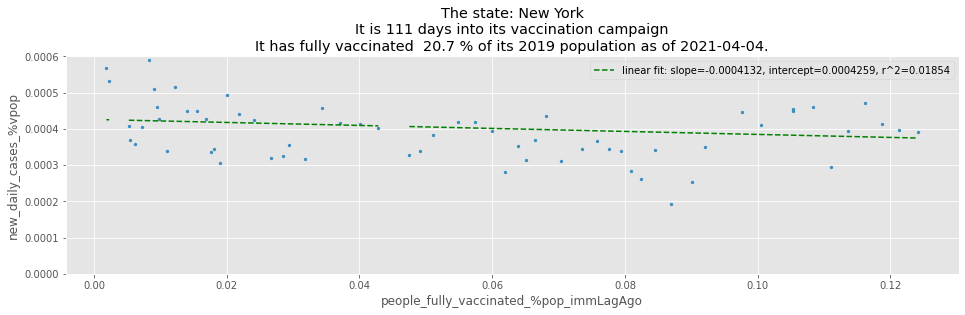

In [113]:
vaxed = latest_adj_vax.iloc[16]
most_vaxed_state_data = state_level_cvd_and_vax[state_level_cvd_and_vax['state'] == vaxed.location].copy()

# cases
ax1 = most_vaxed_state_data.plot.scatter(
    x='people_fully_vaccinated_%pop_immLagAgo', y='new_daily_cases_%vpop', figsize=(16,4), s=8)

vaxed_reg = do_linregress(
    df=most_vaxed_state_data, 
    xcol='people_fully_vaccinated_%pop_immLagAgo', 
    ycol='new_daily_cases_%vpop'
)
plt.plot(
    most_vaxed_state_data['people_fully_vaccinated_%pop_immLagAgo'], 
    most_vaxed_state_data['people_fully_vaccinated_%pop_immLagAgo']*vaxed_reg.slope+vaxed_reg.intercept,
    'g--', label='linear fit: slope={:3.4}, intercept={:3.4}, r^2={:3.4}'.format(
        vaxed_reg.slope,vaxed_reg.intercept,math.pow(vaxed_reg.rvalue,2)))
ax1.legend(loc="upper right")

ax1.set_ylim(0.,.0006)

title = "\n".join([
    "The state: {}",
    "It is {} days into its vaccination campaign",
    "It has fully vaccinated {:5.3} % of its 2019 population as of {}."]).format(
    vaxed.location, vaxed.days_from_start, vaxed['people_fully_vaccinated_%pop']*100, vaxed.date.date())
ax1.set_title(title)
print()

In [167]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import KBinsDiscretizer
import sklearn.metrics
from sklearn.tree import export_graphviz


explained var 0.17108985473026528
max_error 0.0007851751199483585


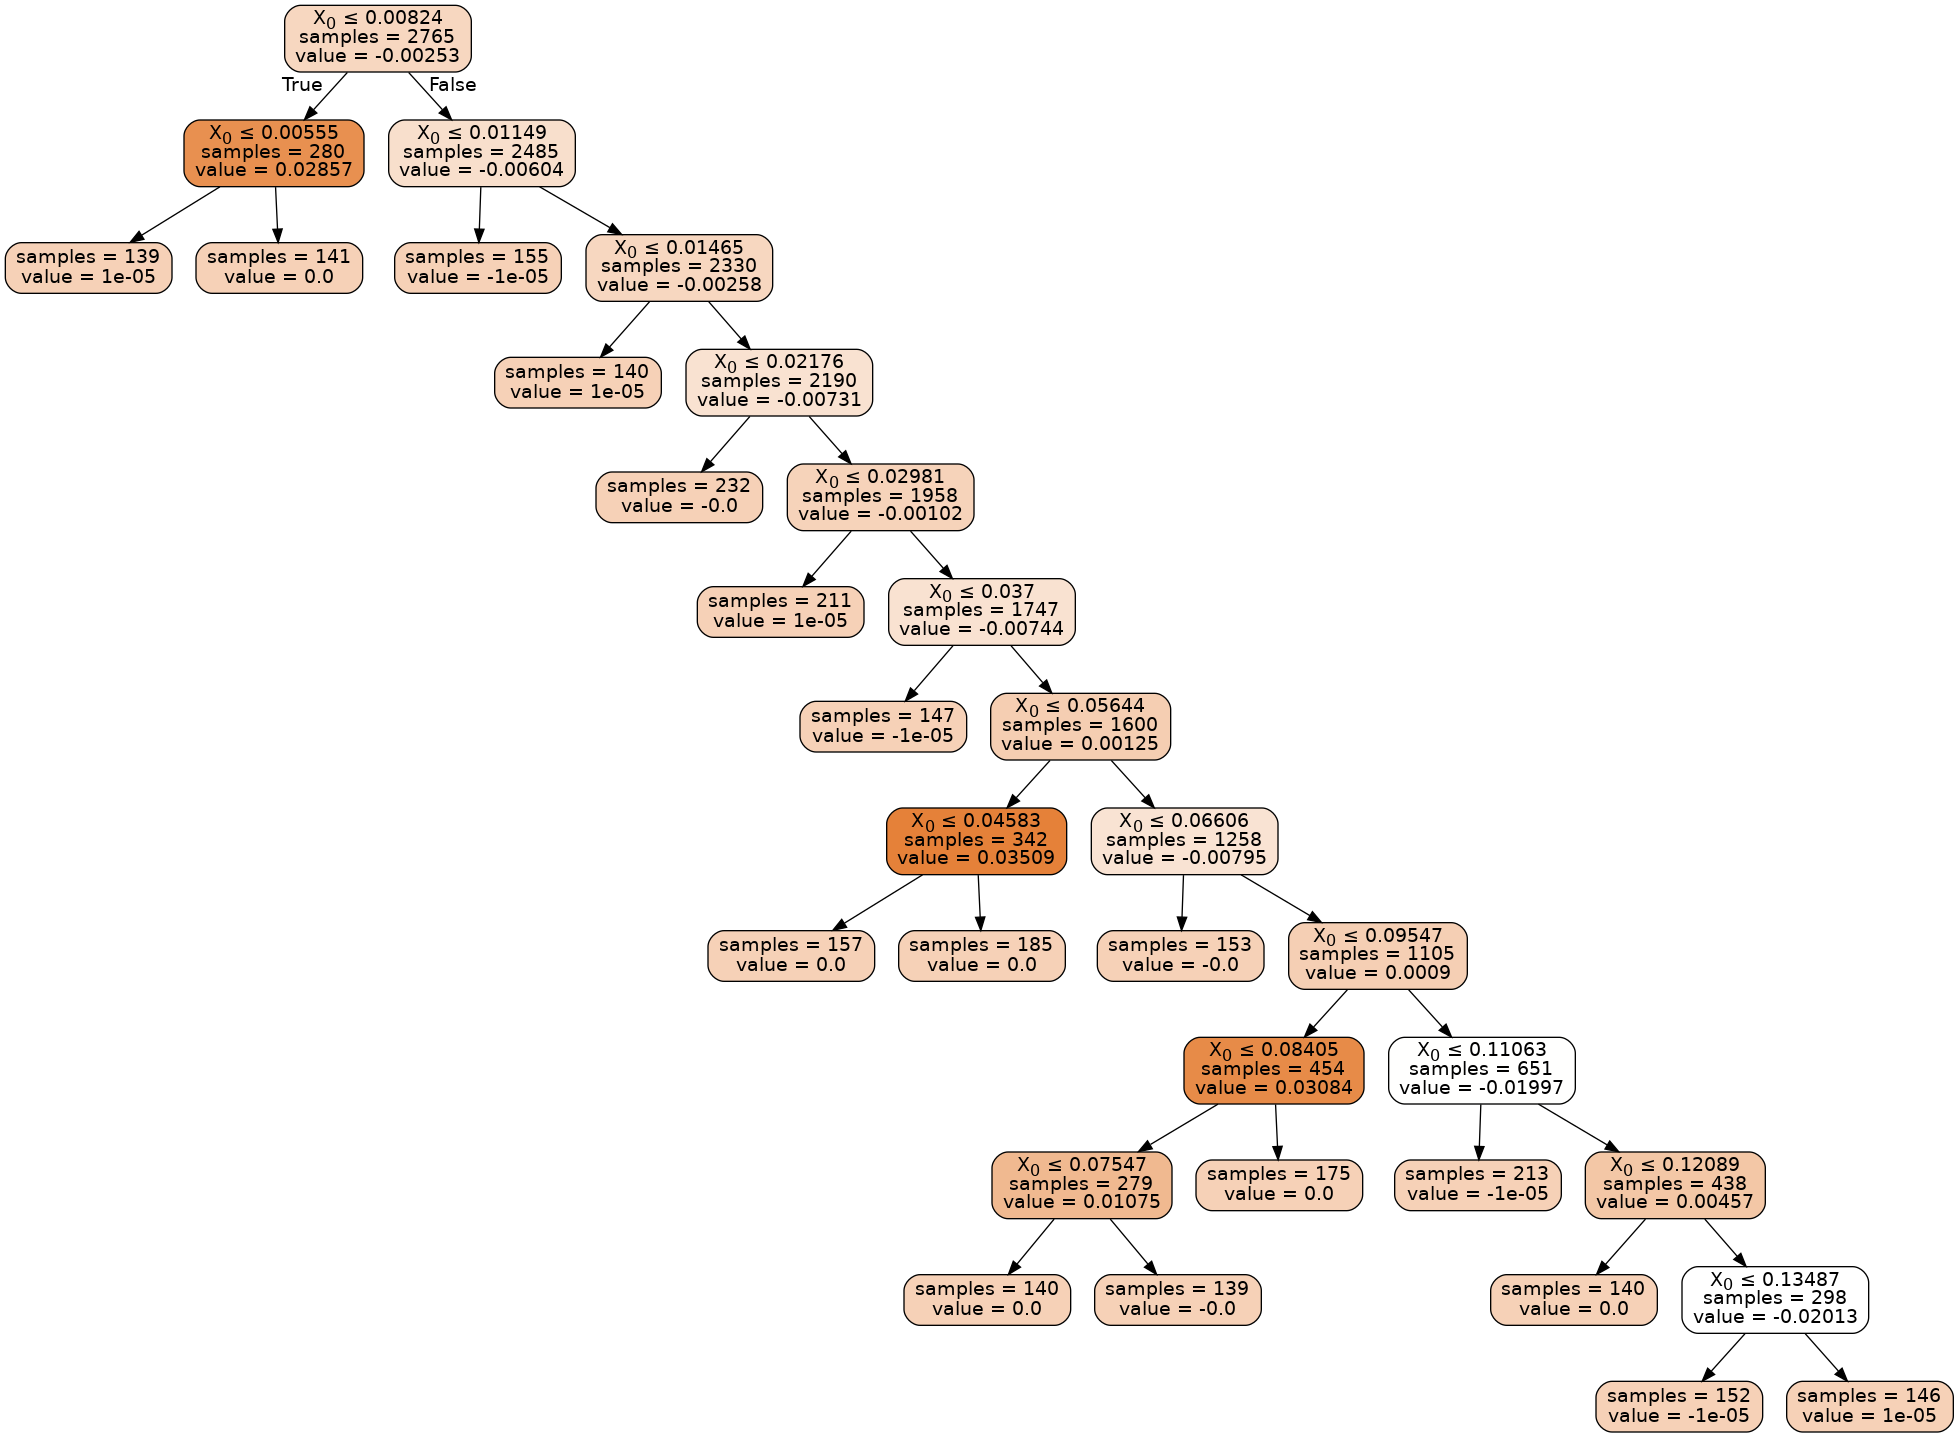

In [170]:
def get_expdata(df, xcol, ycol):
    return df.dropna(subset=[xcol, ycol], how='any').copy()


xcol = 'people_fully_vaccinated_%pop_immLagAgo'
ycol = 'new_daily_cases_%vpop'
expdata = get_expdata(df=state_level_cvd_and_vax, xcol=xcol, ycol=ycol)

X = expdata[xcol]
y = expdata[ycol]
binner = KBinsDiscretizer(encode='ordinal')
stratify = binner.fit_transform(X=expdata[xcol].values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=stratify, test_size=0.15)
mod = GradientBoostingRegressor(loss='lad',max_depth=100,min_weight_fraction_leaf=0.05)
mod.fit(X_train.values.reshape(-1, 1), y_train,)
# mod.score(X_test.values.reshape(-1, 1), y_test)
print('explained var', sklearn.metrics.explained_variance_score(y_true=y_test,y_pred=mod.predict(X_test.values.reshape(-1, 1)),),)
print('max_error', sklearn.metrics.max_error(y_true=y_test,y_pred=mod.predict(X_test.values.reshape(-1, 1)),),)

# Get the tree number 42
sub_tree_42 = mod.estimators_[42, 0]

# Visualization. Install graphviz in your system
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
    precision=5
)
graph = graph_from_dot_data(dot_data,)
Image(graph.create_png())

In [172]:
3*600/40

45.0

Let's see if there is a statistically significant difference between the relationship between full vaccination and new cases between the fastests and slowest vaccinating state.  We find the regression results from both states

In [72]:
# article2
v_pace.dropna(how='any')[list(bot_pace_states[1.])].plot(
    grid=True, kind='line',figsize=(12,4),
    ylabel='%pop ({})'.format(pace_measure.replace('adj_','')), 
    xticks=list(range(v_pace.dropna(how='any').index.min(), 
                      v_pace.dropna(how='any').index.max(),1)),
    title='Pace of States that Were Bottom3 Fastest to Administer Vaccines, before CDC Policy Change'
)
v_pace.dropna(how='any')[list(bot_pace_states[0.])].plot(
    grid=True, kind='line',figsize=(12,4),
    ylabel='%pop ({})'.format(pace_measure.replace('adj_','')), 
    xticks=list(range(v_pace.dropna(how='any').index.min(), 
                      v_pace.dropna(how='any').index.max(),1)),
    title='Pace of States that Were Bottom3 Fastest to Administer Vaccines, after CDC Policy Change'
)


NameError: name 'bot_pace_states' is not defined

In [38]:
dod_adj_vax[['date','location','people_vaccinated','people_vaccinated_yesterday',
             'dod_diff_state_people_vaccinated','dod_%diff_state_people_vaccinated',
             'is_cdc_start', 'is_before_cdc']]

,date,location,people_vaccinated,people_vaccinated_yesterday,dod_diff_state_people_vaccinated,dod_%diff_state_people_vaccinated,dod_%diff_state_people_vaccinated_stds,is_cdc_start,is_before_cdc
0,2021-01-12,Alabama,70861.0,NaN,NaN,NaN,None,False,1.0
1,2021-01-13,Alabama,74792.0,70861.0,3931.0,0.055475,None,False,1.0
2,2021-01-14,Alabama,80480.0,74792.0,5688.0,0.076051,None,False,1.0
3,2021-01-15,Alabama,86956.0,80480.0,6476.0,0.080467,None,False,1.0
4,2021-01-16,Alabama,NaN,86956.0,NaN,NaN,None,False,1.0
...,...,...,...,...,...,...,...,...,...
5283,2021-03-29,Wyoming,156608.0,147413.0,9195.0,0.062376,None,False,0.0
5284,2021-03-30,Wyoming,156638.0,156608.0,30.0,0.000192,None,False,0.0
5285,2021-03-31,Wyoming,156910.0,156638.0,272.0,0.001736,None,False,0.0
5286,2021-04-01,Wyoming,161055.0,156910.0,4145.0,0.026416,None,False,0.0


In [33]:
state = 'District of Columbia'
tmpdf = adj_vax[adj_vax['location'] == state][['date','people_vaccinated']]
tmpdf['shift1'] = tmpdf['people_vaccinated'].shift(1)
[obj['date'] for obj in tmpdf.to_dict('records') if obj['people_vaccinated'] < obj['shift1']]

[Timestamp('2021-02-22 00:00:00')]

In [34]:
non_monotonic_on_measure = {}
for state in state_to_start.keys():
    test = adj_vax[adj_vax['location'] == state]['people_vaccinated'].dropna().is_monotonic
    if not test:
        tmpdf = adj_vax[adj_vax['location'] == state][['date','people_vaccinated']]
        tmpdf['shift1'] = tmpdf['people_vaccinated'].shift(1)
        non_monotonic_on_measure[state] = [obj['date'] for obj in tmpdf.to_dict('records') if obj['people_vaccinated'] < obj['shift1']]

In [35]:
non_monotonic_on_measure

{'Arizona': [Timestamp('2021-02-22 00:00:00')],
 'Colorado': [Timestamp('2021-01-23 00:00:00')],
 'Connecticut': [Timestamp('2021-03-13 00:00:00')],
 'Delaware': [Timestamp('2021-02-22 00:00:00')],
 'District of Columbia': [Timestamp('2021-02-22 00:00:00')],
 'Florida': [Timestamp('2021-01-25 00:00:00'),
  Timestamp('2021-02-22 00:00:00')],
 'Georgia': [Timestamp('2021-02-22 00:00:00')],
 'Hawaii': [Timestamp('2021-01-23 00:00:00')],
 'Iowa': [Timestamp('2021-01-14 00:00:00')],
 'Louisiana': [Timestamp('2021-02-22 00:00:00')],
 'Missouri': [Timestamp('2021-02-22 00:00:00')],
 'New Jersey': [Timestamp('2021-01-14 00:00:00')],
 'North Carolina': [Timestamp('2021-02-22 00:00:00')],
 'North Dakota': [Timestamp('2021-02-22 00:00:00')],
 'Tennessee': [Timestamp('2021-02-22 00:00:00')],
 'Texas': [Timestamp('2021-02-25 00:00:00'), Timestamp('2021-03-24 00:00:00')],
 'Utah': [Timestamp('2021-02-22 00:00:00')],
 'West Virginia': [Timestamp('2021-02-22 00:00:00')]}

In [ ]:
These are states that have at least one negative day.

In [294]:
df2 = pd.merge(
    left=cvd.df, right=oxf.df, 
    how='inner', left_on=['date', 'state'], 
    right_on=['date', 'state_name']
)
del df2['state_name']
df2.sort_values(by=['date','state'],inplace=True)

In [295]:
df2

,date,state,fips,cases,deaths,key,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,...,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,vaccination_policy,stringency_index
0,2020-03-13,Alabama,1,6,0,US_AL,1.0,1.0,1.0,0.0,...,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,26.85
1,2020-03-13,Alaska,2,1,0,US_AK,1.0,1.0,1.0,0.0,...,0.0,0.0,2.0,1.0,2.0,NaN,NaN,0.0,0.0,29.63
2,2020-03-13,Arizona,4,9,0,US_AZ,1.0,1.0,0.0,0.0,...,NaN,NaN,2.0,1.0,1.0,NaN,NaN,0.0,0.0,26.85
3,2020-03-13,Arkansas,5,7,0,US_AR,1.0,1.0,1.0,2.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,26.39
4,2020-03-13,California,6,320,5,US_CA,2.0,1.0,2.0,2.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,43.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19393,2021-03-29,Wisconsin,55,634662,7278,US_WI,2.0,1.0,1.0,4.0,...,0.0,0.0,2.0,3.0,2.0,0.0,0.0,3.0,3.0,56.02
19394,2021-03-29,Wyoming,56,56190,695,US_WY,1.0,1.0,1.0,2.0,...,NaN,NaN,2.0,3.0,1.0,NaN,NaN,2.0,3.0,51.85
19395,2021-03-30,Hawaii,15,29689,459,US_HI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
19396,2021-03-30,Montana,30,104456,1437,US_MT,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
